In [1]:
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/FYP/"

/content/drive/MyDrive/FYP


In [3]:
!unzip "Magnetic_Tile.zip" -d "/content"
clear_output()

# SEMANTIC SEGMENTATION ON MAGNETIC TILE SURFACE DEFECTS

<table style="position:relative; right:50px;">
    <tr><td colspan="3" rowspan="12"><img src="https://github.com/abin24/Magnetic-tile-defect-datasets./raw/master/dataset.jpg" width=350></td></tr>
    <tr><td><b>Benchmark Reference</b></td> 
        <td colspan="2"><a href="https://github.com/abin24/Magnetic-tile-defect-datasets.">Surface Defect Saliency of Magnetic Tile</a></td></tr>
    <tr><td><b>Number of Classes</b></td> 
        <td>6</td>
        <td><b>Blowhole</b></td></tr>
    <tr><td></td>
        <td></td>
        <td><b>Crack</b></td></tr>
    <tr><td></td>
        <td></td>
        <td><b>Break</b></td></tr>
    <tr><td></td>
        <td></td>
        <td><b>Fray</b></td></tr>
    <tr><td></td>
        <td></td>
        <td><b>Uneven</b></td></tr>
    <tr><td></td>
        <td></td>
        <td><b>Free</b></td></tr>
    <tr><td><b>Number of Samples</b></td>
        <td>1344</td>
        <td><b>392 (Defect)</b></td></tr>
    <tr><td></td>
        <td></td>
        <td><b>952 (Defect-Free)</b></td></tr>
    <tr><td><b>Image Property</b></td>
        <td>Grayscale</td>
        <td></td></tr>
    <tr><td><b>Image Size</b></td>
        <td>Vary</td>
        <td></td></tr>
</table>

## TABLE OF CONTENTS
0. [CHAPTER 0: IMPORT NECESSARY PYTHON LIBRARIES](#CHAPTER-0:-IMPORT-NECESSARY-PYTHON-LIBRARIES)
1. [CHAPTER 1: DATA PREPARATION](#CHAPTER-1:-DATA-PREPARATION)
2. [CHAPTER 2: DATA PRE-PROCESSING](#CHAPTER-2:-DATA-PRE-PROCESSING)
3. [CHAPTER 3: MODEL CONSTRUCTION](#CHAPTER-3:-MODEL-CONSTRUCTION)
4. [CHAPTER 4: MODEL TRAINING](#CHAPTER-4:-MODEL-TRAINING)
5. [CHAPTER 5: MODEL EVALUATION](#CHAPTER-5:-MODEL-EVALUATION)
6. [CHAPTER 6: MODEL TESTING](#CHAPTER-6:-MODEL-TESTING)
7. [EXTRA: DEMO](#EXTRA:-DEMO)

## CHAPTER 0: IMPORT NECESSARY PYTHON LIBRARIES

In [4]:
import os
import cv2
import time
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## CHAPTER 1: DATA PREPARATION

In [5]:
# set some global parameters
BATCH_SIZE = 5    # Number of training examples utilized in one iteration
IMG_WIDTH = 96    
IMG_HEIGHT = 96
IMG_CHANNELS = 3

HOME_PATH = 'Magnetic_Tile'
IMG_PATH = '/content/Magnetic_Tile'
MASK_PATH = '/content/Magnetic_Tile'

In [6]:
# get Image and Mask IDs
from imutils import paths
ImagePaths = list(paths.list_images(IMG_PATH, "jpg")) # Only get .jpg filepaths
MaskPaths = list(paths.list_images(MASK_PATH, "png")) # Only get .png filepaths
print(len(ImagePaths), len(MaskPaths))

9632 9632


In [7]:
ImagePaths.sort()
MaskPaths.sort()

In [8]:
# declare two lists to store all the input images and masks
images = []
masks = []

In [9]:
# loop over the image paths
for imagePath in ImagePaths:
    # load the image, and resize it to be a fixed pixels, ignoring aspect ratio
    image = cv2.imread(imagePath)
    # set cv2.INTER_AREA as the image resize interpolation method as it typically yields more aesthetically pleasing results
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)

    # update the data and labels lists, respectively
    images.append(image)

In [10]:
# loop over the image paths
for maskPath in MaskPaths:
    # load the image, and resize it to be a fixed pixels, ignoring aspect ratio
    mask = cv2.imread(maskPath, 0)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)

    # update the data and labels lists, respectively
    masks.append(mask)

## CHAPTER 2: DATA PRE-PROCESSING

In [11]:
# convert the data into a NumPy array, then preprocess it by scaling all pixel intensities to the range [0, 1]
images = np.array(images, dtype="float64") / 255.
masks = np.array(masks, dtype="float64") / 255.
print(images.shape, masks.shape)

(9632, 96, 96, 3) (9632, 96, 96)


In [13]:
# change pixel level masks to boolean type (True / False)
compared_mask = np.zeros((masks.shape[0], IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

masks = masks.reshape((masks.shape[0], IMG_HEIGHT, IMG_WIDTH, 1))
masks = np.maximum(masks, compared_mask)
masks = (masks > 0).astype(bool)

In [ ]:
# get the class label for each of the samples
labels = []
LABELS = os.listdir(IMG_PATH)

for i in range(len(LABELS)):
    for j in os.listdir(os.path.join(IMG_PATH, LABELS[i], "Imgs")):
        if j.endswith(".jpg"):
            labels.append(LABELS[i])
print(len(labels))

9632


In [ ]:
labels.sort()

In [ ]:
# perform one-hot encoding on the labels
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = np.array(labels)

In [ ]:
# partition the data into training and testing splits
from sklearn.model_selection import train_test_split
split = train_test_split(images, masks, labels, test_size=0.10, stratify=labels, random_state=1)

# unpack the data split (training & testing)
(train_images, test_images) = split[:2]
(train_masks, test_masks) = split[2:4]
(train_labels, test_labels) = split[4:]

# partition the data into training and validation splits
split = train_test_split(train_images, train_masks, train_labels, test_size=0.10, stratify=train_labels, random_state=1)

# unpack the data split (training & validation)
(train_images, val_images) = split[:2]
(train_masks, val_masks) = split[2:4]
(train_labels, val_labels) = split[4:]

In [ ]:
# map the class label to every pixel of the masks
val_labels_iou = np.zeros(val_masks.shape)
train_labels_iou = np.zeros(train_masks.shape)
test_labels_iou = np.zeros(test_masks.shape)

# classify the pixel as 'free' if it has no defect (False)
for i in range(val_masks.shape[0]):
    val_labels_iou[i] = np.where(val_masks[i] == True, val_labels[i], 4)

for i in range(train_masks.shape[0]):
    train_labels_iou[i] = np.where(train_masks[i] == True, train_labels[i], 4)

for i in range(test_masks.shape[0]):
    test_labels_iou[i] = np.where(test_masks[i] == True, test_labels[i], 4)

In [ ]:
# CLASS IMBALANCE
def add_sample_weights(label=train_labels_iou):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tensorflow.constant([10.0, 5.0, 7.5, 2.0, 1.0, 2.0])
  class_weights = class_weights/tensorflow.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights`
  sample_weights = tensorflow.gather(class_weights, indices=tensorflow.cast(label, tensorflow.int32))

  return sample_weights.numpy()

In [ ]:
# transforming images and labelled masks together
from keras.preprocessing.image import ImageDataGenerator
seed = 1
# data_gen_args = dict(rotation_range=90,      # rotation
#                      width_shift_range=0.2,  # horizontal shift
#                      height_shift_range=0.2, # vertical shift
#                      zoom_range=[0.5,1.0]    # zoom
#                     )

# train_datagen = ImageDataGenerator(**data_gen_args)
train_datagen = ImageDataGenerator()

# train_datagen.fit(train_images, augment=True, seed=seed)
train_datagen.fit(train_images, augment=False, seed=seed)

train_generator = train_datagen.flow(x=train_images,
                                     y=train_labels_iou,
                                     sample_weight=add_sample_weights(),
                                     batch_size=BATCH_SIZE,
                                     shuffle=True, 
                                     seed=seed)

In [ ]:
# creating the validation Image and Mask generator
val_datagen = ImageDataGenerator()

val_datagen.fit(val_images, augment=False, seed=seed)

val_generator = val_datagen.flow(x=val_images,
                                 y=val_labels_iou,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 seed=seed)

In [ ]:
# creating the testing Image and Mask generator
test_datagen = ImageDataGenerator()

test_datagen.fit(test_images, augment=False, seed=seed)

test_generator = test_datagen.flow(x=test_images,
                                   y=test_labels_iou,
                                   batch_size=BATCH_SIZE,
                                   shuffle=True, 
                                   seed=seed)

In [ ]:
# visualize the mask with coloured defects
def label2Color(mask):
    colorMask = np.zeros(mask.shape)
    mask = np.where(mask == 0, [255, 0, 0], mask)   # MT_Blowhole (Red)
    mask = np.where(mask == 1, [0, 255, 0], mask)   # MT_Break (Green)
    mask = np.where(mask == 2, [0, 0, 255], mask)   # MT_Crack (Blue)
    mask = np.where(mask == 3, [255, 255, 0], mask) # MT_Fray (Yellow)
    mask = np.where(mask == 4, [0, 0, 0], mask)     # MT_Free (Black)
    mask = np.where(mask == 5, [127, 0, 255], mask) # MT_Uneven (Purple)
    return mask.astype("int64")

In [ ]:
from tensorflow.keras.utils import array_to_img

def display(display_list):
  plt.figure(figsize=(7, 7))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i == 1 or i == 2:
        plt.imshow(array_to_img(label2Color(display_list[i])))
    else:
        plt.imshow(array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

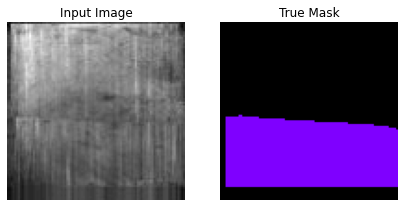

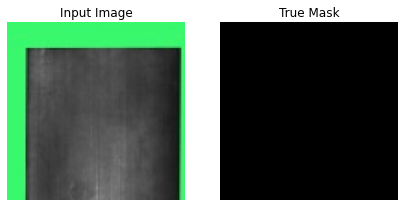

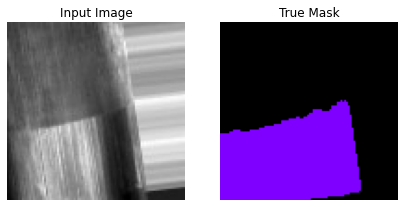

In [ ]:
image, label, weights = next(iter(train_generator))
display([image[0], label[0]])
image, label = next(iter(val_generator))
display([image[1], label[1]])
image, label = next(iter(test_generator))
display([image[2], label[2]])

## CHAPTER 3: MODEL ARCHITECTURE CONSTRUCTION

In [ ]:
!pip install einops
!pip install tensorflow-addons
!pip install --quiet vit-keras
!pip install -q git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 30.9 MB/s 
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import math
import tensorflow_addons as tfa
from einops import rearrange
from tensorflow.image import extract_patches
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Embedding, LayerNormalization, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, Dropout, Permute, ReLU, Softmax
from tensorflow.keras.layers import Concatenate, Reshape, Add, Multiply
from tensorflow.keras.activations import gelu, relu, softmax, sigmoid
from tensorflow.keras.layers import Flatten, UpSampling2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU, BinaryIoU
from keras import backend as K

In [ ]:
# initialize our initial learning rate, number of epochs to train for
INIT_LR = 2e-5
NUM_EPOCHS = 50
WEIGHT_DECAY = 1e-5

In [ ]:
def create_mask(pred_mask):
  pred_mask = tensorflow.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tensorflow.newaxis]
  return pred_mask[0]

In [ ]:
# visualize and compare predicted mask output with ground truth mask
def show_predictions(dataset=train_generator):
    image, label, weight = next(iter(dataset))
    pred_mask = model.predict(image)
    display([image[0], label[0], create_mask(pred_mask)])

In [ ]:
class mean_iou(tensorflow.keras.metrics.MeanIoU):
  def update_state(self, y_true, y_pred, sample_weight=None):
      return super().update_state(y_true, tensorflow.argmax(y_pred, axis=3), sample_weight)

#### Transformer Configuration

In [ ]:
class MultiHeadSelfAttention(tensorflow.keras.layers.Layer):
    def __init__(self, *args, num_heads, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_heads = num_heads

    def build(self, input_shape):
        hidden_size = input_shape[-1]
        num_heads = self.num_heads
        if hidden_size % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {hidden_size} should be divisible by number of heads = {num_heads}"
            )
        self.hidden_size = hidden_size
        self.projection_dim = hidden_size // num_heads
        self.query_dense = tensorflow.keras.layers.Dense(hidden_size, name="query")
        self.key_dense = tensorflow.keras.layers.Dense(hidden_size, name="key")
        self.value_dense = tensorflow.keras.layers.Dense(hidden_size, name="value")
        self.combine_heads = tensorflow.keras.layers.Dense(hidden_size, name="out")

    def attention(self, query, key, value):
        score = tensorflow.matmul(query, key, transpose_b=True)
        dim_key = tensorflow.cast(tensorflow.shape(key)[-1], score.dtype)
        scaled_score = score / tensorflow.math.sqrt(dim_key)
        weights = tensorflow.nn.softmax(scaled_score, axis=-1)
        output = tensorflow.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tensorflow.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tensorflow.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tensorflow.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tensorflow.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tensorflow.reshape(attention, (batch_size, -1, self.hidden_size))
        output = self.combine_heads(concat_attention)
        return output, weights

    def get_config(self):
        config = super().get_config()
        config.update({"num_heads": self.num_heads})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
class TransformerBlock(tensorflow.keras.layers.Layer):
    """Implements a Transformer block."""

    def __init__(self, *args, num_heads, mlp_dim, dropout, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.att = MultiHeadSelfAttention(
            num_heads=self.num_heads,
            name="MultiHeadDotProductAttention_1",
        )
        self.mlpblock = tensorflow.keras.Sequential(
            [
                tensorflow.keras.layers.Dense(
                    self.mlp_dim,
                    activation="linear",
                    name=f"{self.name}/Dense_0",
                ),
                tensorflow.keras.layers.Lambda(
                    lambda x: tensorflow.keras.activations.gelu(x, approximate=False)
                )
                if hasattr(tensorflow.keras.activations, "gelu")
                else tensorflow.keras.layers.Lambda(
                    lambda x: tensorflow.activations.gelu(x, approximate=False)
                ),
                tensorflow.keras.layers.Dropout(self.dropout),
                tensorflow.keras.layers.Dense(input_shape[-1], name=f"{self.name}/Dense_1"),
                tensorflow.keras.layers.Dropout(self.dropout),
            ],
            name="MlpBlock_3",
        )
        self.layernorm1 = tensorflow.keras.layers.LayerNormalization(
            epsilon=1e-6, name="LayerNorm_0"
        )
        self.layernorm2 = tensorflow.keras.layers.LayerNormalization(
            epsilon=1e-6, name="LayerNorm_2"
        )
        self.dropout_layer = tensorflow.keras.layers.Dropout(self.dropout)

    def call(self, inputs, training):
        x = self.layernorm1(inputs)
        x, weights = self.att(x)
        x = self.dropout_layer(x, training=training)
        x = x + inputs
        y = self.layernorm2(x)
        y = self.mlpblock(y)
        return x + y, weights

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "mlp_dim": self.mlp_dim,
                "dropout": self.dropout,
            }
        )
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
# pretrained vit model on ImageNet
from vit_keras import vit
from vit_keras import visualize
vit = vit.vit_b16(
    image_size = IMG_HEIGHT,
    activation = 'linear',
    pretrained = True,
    include_top = False,
    pretrained_top = False,
    classes = len(lb.classes_))

347512832/347502902 [==============================] - 32s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 6, 6
  UserWarning,


#### MODEL 1: FCN
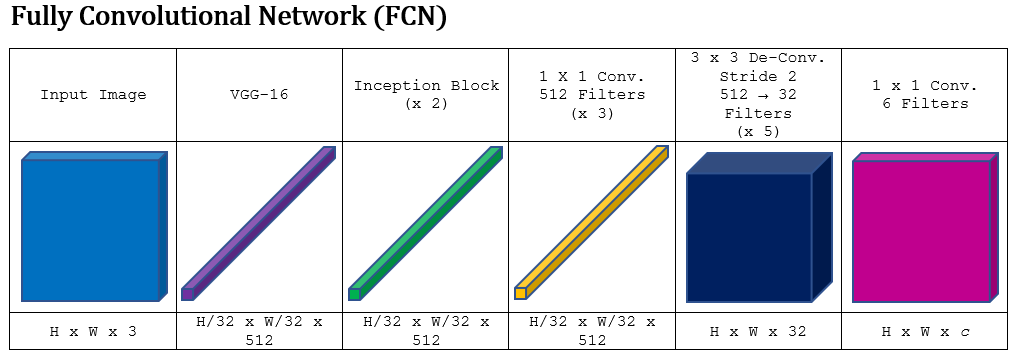

In [ ]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
vgg.trainable = False
intermediate = vgg.output

In [ ]:
# construct a fully-connected layer header to output the predicted labelled mask
# inception block 1: 1st
INCEP1_1 = Conv2D(128, (1, 1), strides = (1, 1), activation="relu")(intermediate)
INCEP1_1 = Conv2D(256, (3, 3), strides = (1, 1), padding="same", activation="relu")(INCEP1_1)
# inception block 1: 2nd
INCEP1_2 = Conv2D(32, (1, 1), strides = (1, 1), activation="relu")(intermediate)
INCEP1_2 = Conv2D(64, (5, 5), strides = (1, 1), padding="same", activation="relu")(INCEP1_2)
# inception block 1: 3rd
INCEP1_3 = MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "same")(intermediate)
INCEP1_3 = Conv2D(64, (1, 1), strides = (1, 1), activation="relu")(INCEP1_3)
# inception block 1: 4th
INCEP1_4 = Conv2D(128, (1, 1), strides = (1, 1), activation="relu")(intermediate)
maskIncepBlock1 = Concatenate()([INCEP1_1, INCEP1_2, INCEP1_3, INCEP1_4])

# inception block 2: 1st
INCEP2_1 = Conv2D(128, (1, 1), strides = (1, 1), activation="relu")(maskIncepBlock1)
INCEP2_1 = Conv2D(256, (3, 3), strides = (1, 1), padding="same", activation="relu")(INCEP2_1)
# inception block 2: 2nd
INCEP2_2 = Conv2D(32, (1, 1), strides = (1, 1), activation="relu")(maskIncepBlock1)
INCEP2_2 = Conv2D(64, (5, 5), strides = (1, 1), padding="same", activation="relu")(INCEP2_2)
# inception block 2: 3rd
INCEP2_3 = MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding="same")(maskIncepBlock1)
INCEP2_3 = Conv2D(64, (1, 1), strides = (1, 1), activation="relu")(INCEP2_3)
# inception block 2: 4th
INCEP2_4 = Conv2D(128, (1, 1), strides = (1, 1), activation="relu")(maskIncepBlock1)
maskIncepBlock2 = Concatenate()([INCEP2_1, INCEP2_2, INCEP2_3, INCEP2_4])

maskHead = Conv2D(512, (1, 1), strides = (1, 1), activation="relu")(maskIncepBlock2)
maskHead = Conv2D(512, (1, 1), strides = (1, 1), activation="relu")(maskHead)
maskHead = Conv2D(512, (1, 1), strides = (1, 1), activation="relu")(maskHead)

maskHead = pix2pix.upsample(512, 3)(maskHead)   # 3x3 -> 6x6
maskHead = pix2pix.upsample(256, 3)(maskHead)   # 6x6 -> 12x12
maskHead = pix2pix.upsample(128, 3)(maskHead)   # 12x12 -> 24x24
maskHead = pix2pix.upsample(64, 3)(maskHead)    # 24x24 -> 48x48
maskHead = pix2pix.upsample(32, 3)(maskHead)    # 48x48 -> 96x96

maskHead = Conv2D(len(lb.classes_), (1, 1), activation="softmax", name="mask")(maskHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
    inputs=vgg.input,
    outputs=maskHead)

In [ ]:
losses = {
    "mask": "sparse_categorical_crossentropy",
}

# assign a higher weight as the cross-entropy loss might be as low as 0.1
lossWeights = {
    "mask": 10.0,
}

# initialize the optimizer, compile the model, and show the model summary
opt = Adam(INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 96, 96, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 96, 96, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 48, 48, 64)   0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [ ]:
tensorflow.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


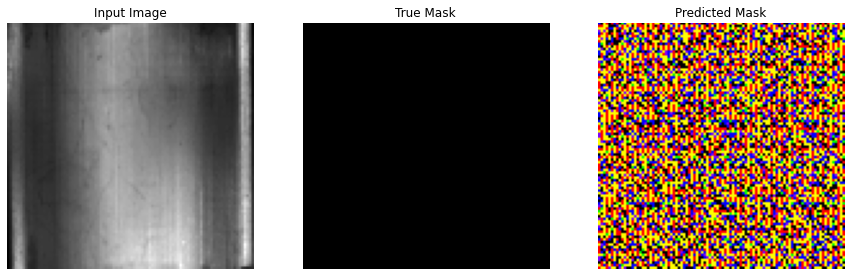

In [ ]:
show_predictions()

#### MODEL 2: DILATEDNET
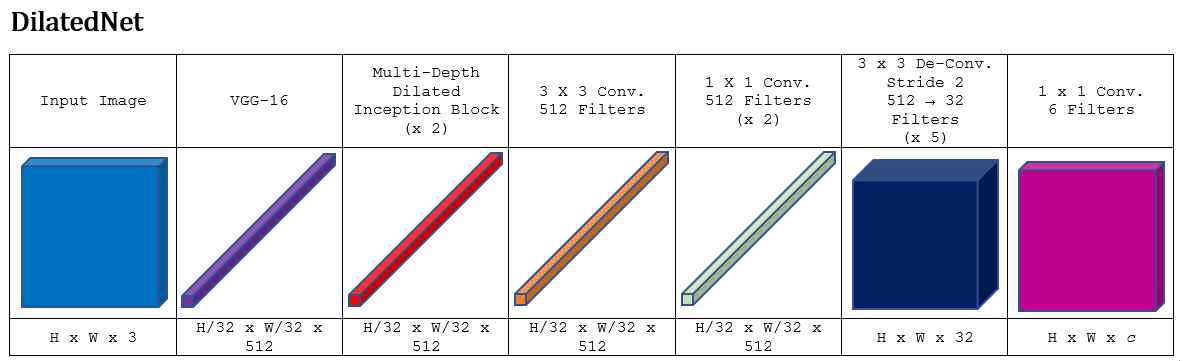

In [ ]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
vgg.trainable = False
intermediate = vgg.get_layer("block5_conv3").output

In [ ]:
# construct a fully-connected layer header to output the predicted labelled mask
maskHead = Conv2D(512, (2, 2), strides = (1, 1), activation="relu")(intermediate)

# multi-depth dilated inception block
# dilated inception block 1: 1st
DILATED_INCEP1_1 = Conv2D(128, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
# dilated inception block 1: 2nd
DILATED_INCEP1_2 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP1_2 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_2)
# dilated inception block 1: 3rd
DILATED_INCEP1_3 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP1_3 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_3)
DILATED_INCEP1_3 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_3)
# dilated inception block 1: 4th
DILATED_INCEP1_4 = Conv2D(256, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP1_4 = Conv2D(256, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_4)
DILATED_INCEP1_4 = Conv2D(256, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_4)
DILATED_INCEP1_4 = Conv2D(256, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_4)
maskDilatedIncepBlock1 = Concatenate()([DILATED_INCEP1_1, DILATED_INCEP1_2, DILATED_INCEP1_3, DILATED_INCEP1_4])

# dilated inception block 2: 1st
DILATED_INCEP2_1 = Conv2D(128, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskDilatedIncepBlock1)
# dilated inception block 2: 2nd
DILATED_INCEP2_2 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskDilatedIncepBlock1)
DILATED_INCEP2_2 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_2)
# dilated inception block 2: 3rd
DILATED_INCEP2_3 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskDilatedIncepBlock1)
DILATED_INCEP2_3 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_3)
DILATED_INCEP2_3 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_3)
# dilated inception block 2: 4th
DILATED_INCEP2_4 = Conv2D(256, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskDilatedIncepBlock1)
DILATED_INCEP2_4 = Conv2D(256, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_4)
DILATED_INCEP2_4 = Conv2D(256, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_4)
DILATED_INCEP2_4 = Conv2D(256, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_4)
maskDilatedIncepBlock2 = Concatenate()([DILATED_INCEP2_1, DILATED_INCEP2_2, DILATED_INCEP2_3, DILATED_INCEP2_4])

maskHead = Conv2D(512, (3, 3), strides = (1, 1), activation="relu")(maskDilatedIncepBlock2)
maskHead = Conv2D(512, (1, 1), strides = (1, 1), activation="relu")(maskHead)
maskHead = Conv2D(512, (1, 1), strides = (1, 1), activation="relu")(maskHead)

maskHead = pix2pix.upsample(512, 3)(maskHead)   # 3x3 -> 6x6
maskHead = pix2pix.upsample(256, 3)(maskHead)   # 6x6 -> 12x12
maskHead = pix2pix.upsample(128, 3)(maskHead)   # 12x12 -> 24x24
maskHead = pix2pix.upsample(64, 3)(maskHead)    # 24x24 -> 48x48
maskHead = pix2pix.upsample(32, 3)(maskHead)    # 48x48 -> 96x96

maskHead = Conv2D(len(lb.classes_), (1, 1), activation="softmax", name="mask")(maskHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
    inputs=vgg.input,
    outputs=maskHead)

In [ ]:
losses = {
    "mask": "sparse_categorical_crossentropy",
}

# assign a higher weight as the cross-entropy loss might be as low as 0.1
lossWeights = {
    "mask": 10.0,
}

# initialize the optimizer, compile the model, and show the model summary
opt = Adam(INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 96, 96, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 96, 96, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 48, 48, 64)   0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [ ]:
tensorflow.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


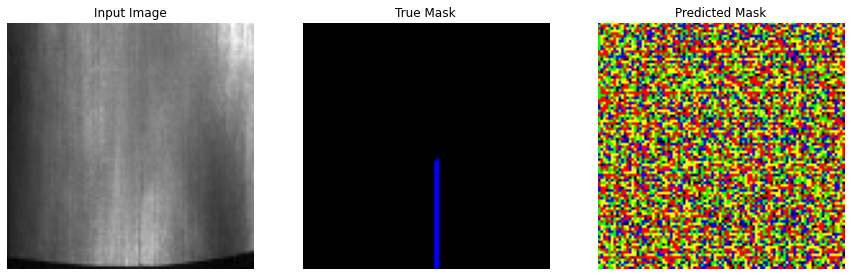

In [ ]:
show_predictions()

#### Model 3: UNET
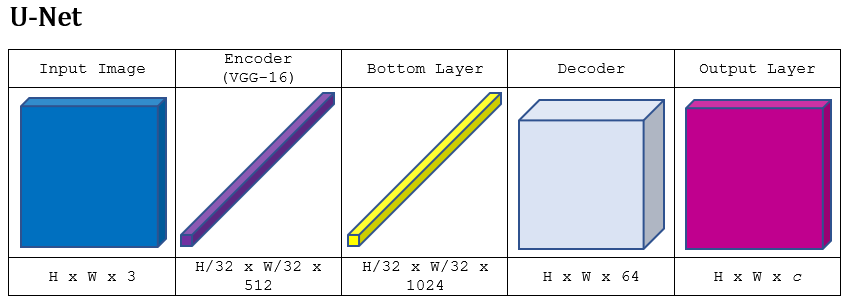

In [ ]:
# contracting part of the architecture
# learn on context information (WHAT)
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
vgg.trainable = False
intermediate = vgg.output

In [ ]:
# expansive part of the architecture
# learn on spatial information (WHERE)
# bottom block and start upsampling
maskHead = Conv2D(1024, (3,3), activation='relu', padding='same')(intermediate)
maskHead = Conv2D(1024, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(512, 3)(maskHead)

# concatenation block 1
maskHead = Concatenate()([vgg.get_layer('block5_conv3').output, maskHead])
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(512, 3)(maskHead)

# concatenation block 2
maskHead = Concatenate()([vgg.get_layer('block4_conv3').output, maskHead])
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(256, 3)(maskHead)

# concatenation block 3
maskHead = Concatenate()([vgg.get_layer('block3_conv3').output, maskHead])
maskHead = Conv2D(256, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(256, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(128, 3)(maskHead)

# concatenation block 4
maskHead = Concatenate()([vgg.get_layer('block2_conv2').output, maskHead])
maskHead = Conv2D(128, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(128, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(64, 3)(maskHead)

# concatenation block 5
maskHead = Concatenate()([vgg.get_layer('block1_conv2').output, maskHead])
maskHead = Conv2D(64, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(64, (3,3), activation='relu', padding='same')(maskHead)

maskHead = Conv2D(len(lb.classes_), (1, 1), activation="softmax", name="mask")(maskHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
    inputs=vgg.input,
    outputs=maskHead)

In [ ]:
losses = {
    "mask": "sparse_categorical_crossentropy",
}

# assign a higher weight as the cross-entropy loss might be as low as 0.1
lossWeights = {
    "mask": 10.0,
}

# initialize the optimizer, compile the model, and show the model summary
opt = Adam(INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 96, 96, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 96, 96, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 48, 48, 64)   0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [ ]:
tensorflow.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


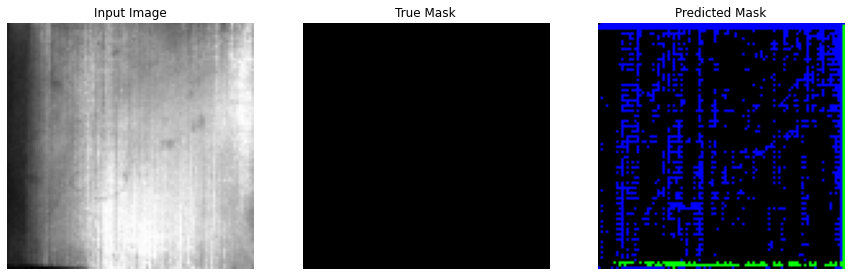

In [ ]:
show_predictions()

#### MODEL 4: DOUBLE U-NET
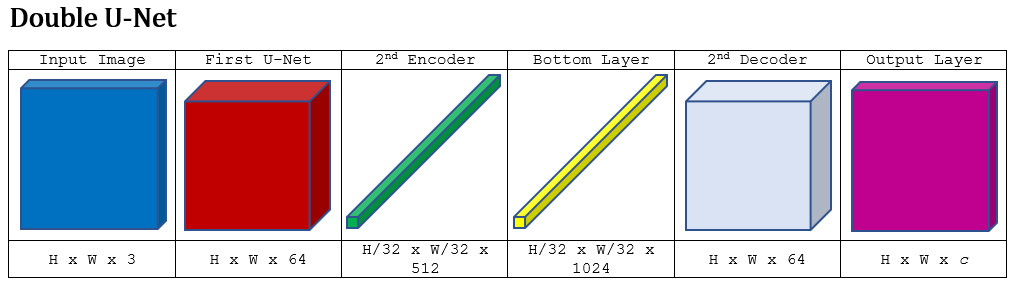

In [ ]:
# load the pretrained UNET network, ensuring the classifier head layers are left off
from tensorflow.keras.models import load_model
UNET = load_model("SEMANTIC_SEGMENTATION_MAGNETIC_TILE_VGGUNET.h5")
for l in UNET.layers:
    l.trainable = False

In [ ]:
# UNET2 - input
unet_input = UNET.layers[-2].output

# UNET2 - multi-depth dilated inception block 1
# dilated inception block 1: 1st
DILATED_INCEP1_1 = Conv2D(24, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(unet_input)
# dilated inception block 1: 2nd
DILATED_INCEP1_2 = Conv2D(4, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(unet_input)
DILATED_INCEP1_2 = Conv2D(8, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_2)
# dilated inception block 1: 3rd
DILATED_INCEP1_3 = Conv2D(2, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(unet_input)
DILATED_INCEP1_3 = Conv2D(4, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_3)
DILATED_INCEP1_3 = Conv2D(8, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_3)
# dilated inception block 1: 4th
DILATED_INCEP1_4 = Conv2D(4, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(unet_input)
DILATED_INCEP1_4 = Conv2D(8, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_4)
DILATED_INCEP1_4 = Conv2D(16, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_4)
DILATED_INCEP1_4 = Conv2D(24, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_4)
maskDilatedIncepBlock1 = Concatenate()([DILATED_INCEP1_1, DILATED_INCEP1_2, DILATED_INCEP1_3, DILATED_INCEP1_4])
maskHead = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(maskDilatedIncepBlock1)

# UNET2 - multi-depth dilated inception block 2
# dilated inception block 2: 1st
DILATED_INCEP2_1 = Conv2D(48, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
# dilated inception block 2: 2nd
DILATED_INCEP2_2 = Conv2D(8, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP2_2 = Conv2D(16, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_2)
# dilated inception block 2: 3rd
DILATED_INCEP2_3 = Conv2D(4, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP2_3 = Conv2D(8, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_3)
DILATED_INCEP2_3 = Conv2D(16, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_3)
# dilated inception block 2: 4th
DILATED_INCEP2_4 = Conv2D(8, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP2_4 = Conv2D(16, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_4)
DILATED_INCEP2_4 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_4)
DILATED_INCEP2_4 = Conv2D(48, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_4)
maskDilatedIncepBlock2 = Concatenate()([DILATED_INCEP2_1, DILATED_INCEP2_2, DILATED_INCEP2_3, DILATED_INCEP2_4])
maskHead = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(maskDilatedIncepBlock2)

# UNET2 - dilated convolutional block 3
# dilated inception block 3: 1st
DILATED_INCEP3_1 = Conv2D(96, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
# dilated inception block 3: 2nd
DILATED_INCEP3_2 = Conv2D(16, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP3_2 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_2)
# dilated inception block 3: 3rd
DILATED_INCEP3_3 = Conv2D(8, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP3_3 = Conv2D(16, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_3)
DILATED_INCEP3_3 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_3)
# dilated inception block 3: 4th
DILATED_INCEP3_4 = Conv2D(16, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP3_4 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_4)
DILATED_INCEP3_4 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_4)
DILATED_INCEP3_4 = Conv2D(96, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_4)
maskDilatedIncepBlock3 = Concatenate()([DILATED_INCEP3_1, DILATED_INCEP3_2, DILATED_INCEP3_3, DILATED_INCEP3_4])
maskHead = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(maskDilatedIncepBlock3)

# UNET2 - dilated convolutional block 4
# dilated inception block 4: 1st
DILATED_INCEP4_1 = Conv2D(192, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
# dilated inception block 4: 2nd
DILATED_INCEP4_2 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP4_2 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_2)
# dilated inception block 4: 3rd
DILATED_INCEP4_3 = Conv2D(16, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP4_3 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_3)
DILATED_INCEP4_3 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_3)
# dilated inception block 4: 4th
DILATED_INCEP4_4 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP4_4 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_4)
DILATED_INCEP4_4 = Conv2D(128, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_4)
DILATED_INCEP4_4 = Conv2D(192, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_4)
maskDilatedIncepBlock4 = Concatenate()([DILATED_INCEP4_1, DILATED_INCEP4_2, DILATED_INCEP4_3, DILATED_INCEP4_4])
maskHead = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(maskDilatedIncepBlock4)

# UNET2 - dilated convolutional block 5
# dilated inception block 5: 1st
DILATED_INCEP5_1 = Conv2D(192, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
# dilated inception block 5: 2nd
DILATED_INCEP5_2 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP5_2 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_2)
# dilated inception block 5: 3rd
DILATED_INCEP5_3 = Conv2D(16, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP5_3 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_3)
DILATED_INCEP5_3 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_3)
# dilated inception block 5: 4th
DILATED_INCEP5_4 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP5_4 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_4)
DILATED_INCEP5_4 = Conv2D(128, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_4)
DILATED_INCEP5_4 = Conv2D(192, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_4)
maskDilatedIncepBlock5 = Concatenate()([DILATED_INCEP5_1, DILATED_INCEP5_2, DILATED_INCEP5_3, DILATED_INCEP5_4])
maskHead = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(maskDilatedIncepBlock5)

# UNET2 - bottom block
maskHead = Conv2D(1024, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2D(1024, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2DTranspose(filters=512, kernel_size=3, strides = (2, 2), activation='relu', padding='same')(maskHead)

# UNET2 - concatenation block 1
maskHead = Concatenate()([maskDilatedIncepBlock5, maskHead])
maskHead = Conv2D(512, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2D(512, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2DTranspose(filters=512, kernel_size=3, strides = (2, 2), activation='relu', padding='same')(maskHead)

# UNET2 - concatenation block 2
maskHead = Concatenate()([maskDilatedIncepBlock4, maskHead])
maskHead = Conv2D(256, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2D(256, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2DTranspose(filters=256, kernel_size=3, strides = (2, 2), activation='relu', padding='same')(maskHead)

# UNET2 - concatenation block 3
maskHead = Concatenate()([maskDilatedIncepBlock3, maskHead])
maskHead = Conv2D(128, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2D(128, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2DTranspose(filters=128, kernel_size=3, strides = (2, 2), activation='relu', padding='same')(maskHead)

# UNET2 - concatenation block 4
maskHead = Concatenate()([maskDilatedIncepBlock2, maskHead])
maskHead = Conv2D(64, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2D(64, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2DTranspose(filters=64, kernel_size=3, strides = (2, 2), activation='relu', padding='same')(maskHead)

# UNET2 - concatenation block 5
maskHead = Concatenate()([maskDilatedIncepBlock1, maskHead])
maskHead = Conv2D(64, (3, 3), padding="same", activation='relu')(maskHead)
maskHead = Conv2D(64, (3, 3), padding="same", activation='relu')(maskHead)

# finale
final_output = Conv2D(len(lb.classes_), (1, 1), activation="softmax", name="mask")(maskHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
    inputs=UNET.input,
    outputs=final_output)

In [ ]:
losses = {
    "mask": "sparse_categorical_crossentropy",
}

# assign a higher weight as the cross-entropy loss might be as low as 0.1
lossWeights = {
    "mask": 10.0,
}

# initialize the optimizer, compile the model, and show the model summary
opt = Adam(INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 96, 96, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 96, 96, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 48, 48, 64)   0           ['block1_conv2[0][0]']           
                                                                                            

In [ ]:
tensorflow.keras.utils.plot_model(model, show_shapes=True)

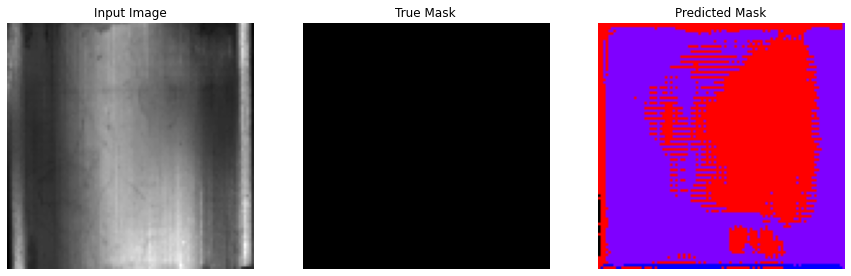

In [ ]:
show_predictions()

#### MODEL 5: SETR
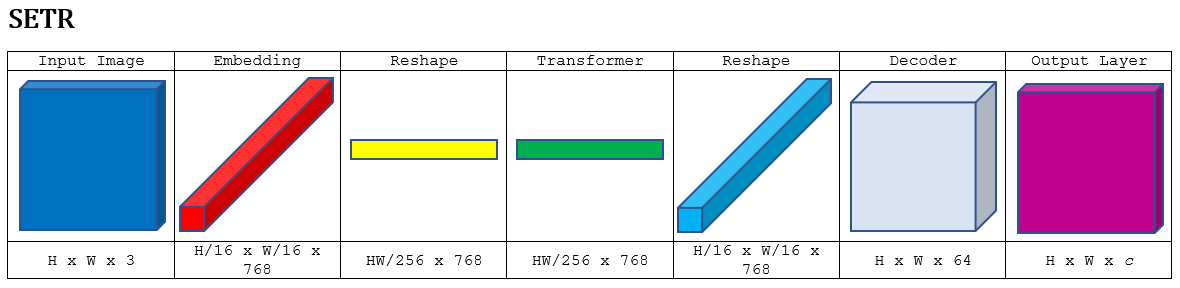

In [ ]:
class PathGeneration(tensorflow.keras.layers.Layer):
  def __init__(self, patch_size=16, **kwargs):
    super(PathGeneration, self).__init__(**kwargs)
    self.patch_size = patch_size
    
  def call(self, images):
    # batch_size = tensorflow.shape(images)[0]
    patches = tensorflow.image.extract_patches(images=images, 
                                               sizes=[1, self.patch_size, self.patch_size, 1], 
                                               strides=[1, self.patch_size, self.patch_size, 1], rates=[1, 1, 1, 1], padding="VALID")
    patch_dims = patches.shape[-1]
    # patches = tensorflow.reshape(patches, [batch_size, -1, patch_dims]) # here shape is (batch_size, num_patches, patch_h*patch_w*c) 
    patches = Reshape((images.shape[0], -1, patch_dims))(patches)
    return patches

  def get_config(self):
    config = super(PathGeneration, self).get_config()
    config.update({"patch_size": self.patch_size})
    return config
  
  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [ ]:
class TransSelfAttention(tensorflow.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(TransSelfAttention, self).__init__(**kwargs)

    self.num_attention_heads = 16
    self.attention_head_size = int(768 / self.num_attention_heads)
    self.all_head_size = self.num_attention_heads * self.attention_head_size

    self.query = Dense(self.all_head_size)
    self.key = Dense(self.all_head_size)
    self.value = Dense(self.all_head_size)

    self.dropout = Dropout(0.1)

  def transpose_for_scores(self, x):
    new_x_shape = x.shape[:-1] + (self.num_attention_heads, self.attention_head_size)
    x = Reshape((new_x_shape[1], new_x_shape[2], new_x_shape[-1]))(x)

    return Permute((2, 1, 3))(x) # (batch_size, num_attention_heads, seq_len, head_size)

  def call(self, x):
    mixed_query_layer = self.query(x)
    mixed_key_layer = self.key(x)
    mixed_value_layer = self.value(x)

    query_layer = self.transpose_for_scores(mixed_query_layer)
    key_layer = self.transpose_for_scores(mixed_key_layer)
    value_layer = self.transpose_for_scores(mixed_value_layer)

    # Take the dot product between "query" and "key" to get the raw attention scores
    attention_scores = tensorflow.matmul(query_layer, tensorflow.transpose(key_layer, perm=[0, 1, 3, 2]))
    attention_scores = attention_scores / math.sqrt(self.attention_head_size)
    
    # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
    attention_scores = attention_scores

    # Normalize the attention scores to probabilities
    attention_probs = Softmax(axis=-1)(attention_scores)

    # This is actually dropping out entire tokens to attend to, which might
    # seem a bit unusual, but is taken from the original Transformer paper.
    attention_probs = self.dropout(attention_probs)

    context_layer = tensorflow.matmul(attention_probs, value_layer)
    context_layer = Permute((2, 1, 3))(context_layer) # (batch_size, length, embedding_dimension)
    new_context_layer_shape = context_layer.shape[:-2] + (self.all_head_size,)
    context_layer = Reshape((new_context_layer_shape[1], new_context_layer_shape[-1]))(context_layer)

    return context_layer

  def get_config(self):
    config = super(TransSelfAttention, self).get_config()
    return config

  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [ ]:
# pretrained deit model on ImageNet
deit_gcs_path = "gs://tfhub-modules/sayakpaul/deit_base_patch16_224/1/uncompressed"
deit = tensorflow.keras.models.load_model(deit_gcs_path)

In [ ]:
## SETR TRANSFORMER CONFIG PARAMS
# x = np.random.rand(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
# b, c, h, w = x.shape

patch_size = 16
hidden_size = 768
sample_rate = 4
sample_v = int(math.pow(2, sample_rate))
num_attention_heads = 16
num_hidden_layers = 12
encoder_dense = 3072
dropout_rate = 0.1
hh = IMG_HEIGHT // patch_size 
ww = IMG_WIDTH // patch_size

x = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
b, c, h, w = x.shape

# InputConv2d
embed_layer = Conv2D(filters=hidden_size, kernel_size=patch_size, strides=patch_size, padding="valid", name="embedding")
INPUTDENSE2D_DENSE = embed_layer(x)
embed_layer.set_weights(vit.get_layer("embedding").get_weights())
INPUTDENSE2D_TRANSLAYERNORM = LayerNormalization(epsilon=1e-6, gamma_initializer='ones', beta_initializer='zeros')(INPUTDENSE2D_DENSE)
INPUTDENSE2D_TRANSLAYERNORM = Reshape((INPUTDENSE2D_TRANSLAYERNORM.shape[1] * INPUTDENSE2D_TRANSLAYERNORM.shape[2], hidden_size))(INPUTDENSE2D_TRANSLAYERNORM)

# path_generation = PathGeneration
# inputs = path_generation(patch_size)(x)

# TransEmbeddings
input_shape = INPUTDENSE2D_TRANSLAYERNORM.shape
seq_length = input_shape[1] #36
position_ids = tensorflow.range(seq_length)
position_ids = tensorflow.expand_dims(position_ids, 0)
position_ids = tensorflow.broadcast_to(position_ids, tensorflow.shape(INPUTDENSE2D_TRANSLAYERNORM)[:2])

TRANSEMBEDDINGS_POSITION_EMBEDDINGS = Embedding(512+1, hidden_size, input_length=hh*ww, name="PosEmbedLayer")(position_ids)
TRANSEMBEDDINGS_EMBEDDINGS = INPUTDENSE2D_TRANSLAYERNORM + TRANSEMBEDDINGS_POSITION_EMBEDDINGS
TRANSEMBEDDINGS_EMBEDDINGS = LayerNormalization(epsilon=1e-6, gamma_initializer='ones', beta_initializer='zeros', name="EmbedLayerNorm")(TRANSEMBEDDINGS_EMBEDDINGS)
TRANSEMBEDDINGS_EMBEDDINGS = Dropout(0.1, name="EmbedDropLayer")(TRANSEMBEDDINGS_EMBEDDINGS)

# TransEncoder - TransLayer
hidden_states = TRANSEMBEDDINGS_EMBEDDINGS
all_encoder_layers = []
for i in range(num_hidden_layers):
   trans_layer = TransformerBlock(
            num_heads=num_attention_heads,
            mlp_dim=encoder_dense,
            dropout=dropout_rate,
            name=f"Transformer/encoderblock_{i}")
   hidden_states, _ = trans_layer(hidden_states)
   trans_layer.set_weights(vit.get_layer(f"Transformer/encoderblock_{i}").get_weights())
ENCODER_FINAL_DENSE = Dense(patch_size * patch_size * hidden_size // (sample_v**2), activation='gelu', name="FinalDenseLayer")(hidden_states)
ENCODER_FINAL_OUTPUT = Reshape((hh*patch_size//sample_v, ww*patch_size//sample_v, hidden_size))(ENCODER_FINAL_DENSE)

# Decoder2D - 1st Decoder
DECODER_1 = Conv2D(512, (3, 3), strides=(1, 1), padding="same", activation="relu", name="DecConvLayer_1")(ENCODER_FINAL_OUTPUT)
DECODER_1 = BatchNormalization(momentum=0.99, epsilon=1e-6, name="DecBatchNorm_1")(DECODER_1)
DECODER_1 = pix2pix.upsample(512, 3)(DECODER_1)

# Decoder2D - 2nd Decoder
DECODER_2 = Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation="relu", name="DecConvLayer_2")(DECODER_1)
DECODER_2 = BatchNormalization(momentum=0.99, epsilon=1e-6, name="DecBatchNorm_2")(DECODER_2)
DECODER_2 = pix2pix.upsample(256, 3)(DECODER_2)

# Decoder2D - 3rd Decoder
DECODER_3 = Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu", name="DecConvLayer_3")(DECODER_2)
DECODER_3 = BatchNormalization(momentum=0.99, epsilon=1e-6, name="DecBatchNorm_3")(DECODER_3)
DECODER_3 = pix2pix.upsample(128, 3)(DECODER_3)

# Decoder2D - 4th Decoder
DECODER_4 = Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu", name="DecConvLayer_4")(DECODER_3)
DECODER_4 = BatchNormalization(momentum=0.99, epsilon=1e-6, name="DecBatchNorm_4")(DECODER_4)
DECODER_4 = pix2pix.upsample(64, 3)(DECODER_4)

# FINALE
FINAL_OUTPUT = Conv2D(len(lb.classes_), (1, 1), strides=(1, 1), activation="softmax", name="mask")(DECODER_4)

model = Model(
    inputs=x,
    outputs=FINAL_OUTPUT)

In [ ]:
# initialize the optimizer, compile the model, and show the model summary
losses = {
    "mask": "sparse_categorical_crossentropy",
}

# assign a higher weight as the cross-entropy loss might be as low as 0.1
lossWeights = {
    "mask": 10.0,
}

# initialize the optimizer, compile the model, and show the model summary
# opt = Adam(INIT_LR)
opt = tfa.optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
model.compile(loss=losses, optimizer=opt, metrics=[mean_iou(num_classes=len(lb.classes_))], loss_weights=lossWeights)
print(model.summary())

In [ ]:
tensorflow.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
show_predictions()

#### MODEL 6: TRANSUNET
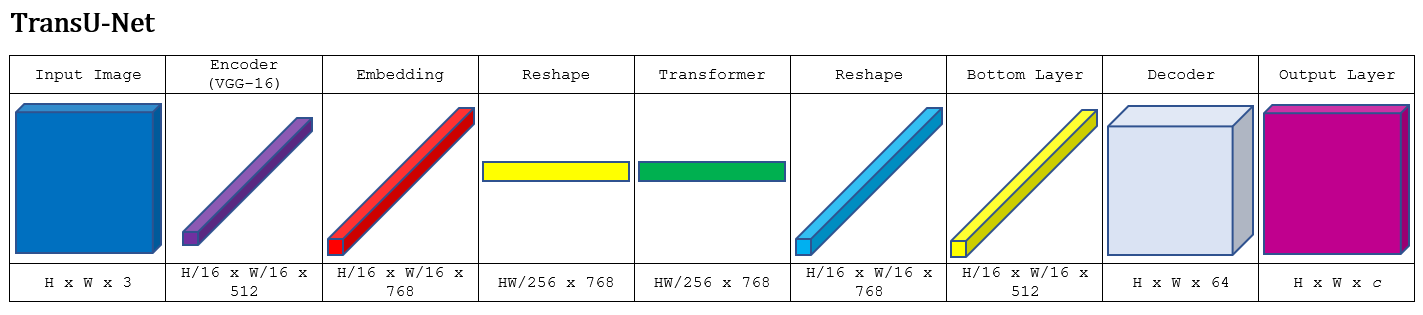

In [ ]:
# contracting part of the architecture
# learn on context information (WHAT)
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
vgg.trainable = False
intermediate = vgg.layers[-2].output

In [ ]:
# trans-encoder part of the architecture
# trans-encoder config params
patch_size = 16
grid = (6,6) 
hidden_size = 768
sample_rate = 4
sample_v = int(math.pow(2, sample_rate))
num_attention_heads = 12
num_hidden_layers = 12
encoder_dense = 3072
dropout_rate = 0.1
hh = IMG_HEIGHT // patch_size
ww = IMG_WIDTH // patch_size

# extract patches from hidden features (shape = [B,H/16*W/16,HIDDEN_SIZE])
cnn_patch_size = IMG_HEIGHT // patch_size // grid[0]
INPUTDENSE2D_DENSE = Conv2D(filters=hidden_size, kernel_size=cnn_patch_size, strides=cnn_patch_size, padding="valid", name="embedding", trainable=True)(intermediate)
INPUTDENSE2D_TRANSLAYERNORM = LayerNormalization(epsilon=1e-12, gamma_initializer='ones', beta_initializer='zeros')(INPUTDENSE2D_DENSE)
INPUTDENSE2D_TRANSLAYERNORM = Reshape((INPUTDENSE2D_TRANSLAYERNORM.shape[1] * INPUTDENSE2D_TRANSLAYERNORM.shape[2], hidden_size))(INPUTDENSE2D_TRANSLAYERNORM)

# position embeddings
input_shape = INPUTDENSE2D_TRANSLAYERNORM.shape
seq_length = input_shape[1]
position_ids = tensorflow.range(seq_length)
position_ids = tensorflow.expand_dims(position_ids, 0)
position_ids = tensorflow.broadcast_to(position_ids, tensorflow.shape(INPUTDENSE2D_TRANSLAYERNORM)[:2])

TRANSEMBEDDINGS_POSITION_EMBEDDINGS = Embedding(512+1, hidden_size, input_length=36, name="PosEmbedLayer")(position_ids)
TRANSEMBEDDINGS_EMBEDDINGS = INPUTDENSE2D_TRANSLAYERNORM + TRANSEMBEDDINGS_POSITION_EMBEDDINGS
TRANSEMBEDDINGS_EMBEDDINGS = LayerNormalization(epsilon=1e-12, gamma_initializer='ones', beta_initializer='zeros', name="EmbedLayerNorm")(TRANSEMBEDDINGS_EMBEDDINGS)
TRANSEMBEDDINGS_EMBEDDINGS = Dropout(0.1, name="EmbedDropLayer")(TRANSEMBEDDINGS_EMBEDDINGS)

# transformer layer
hidden_states = TRANSEMBEDDINGS_EMBEDDINGS
for i in range(num_hidden_layers):
   trans_layer = TransformerBlock(
            num_heads=num_attention_heads,
            mlp_dim=encoder_dense,
            dropout=dropout_rate,
            name=f"Transformer/encoderblock_{i}")
   hidden_states, _ = trans_layer(hidden_states)
   trans_layer.set_weights(vit.get_layer(f"Transformer/encoderblock_{i}").get_weights())
ENCODER_FINAL_DENSE = Dense(patch_size * patch_size * hidden_size // (sample_v**2), activation='gelu', name="FinalDenseLayer")(hidden_states)
ENCODER_FINAL_OUTPUT = Reshape((hh*patch_size//sample_v, ww*patch_size//sample_v, hidden_size))(ENCODER_FINAL_DENSE)

In [ ]:
# expansive part of the architecture
# learn on spatial information (WHERE)
# bottom block and start upsampling
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(ENCODER_FINAL_OUTPUT)
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)

# concatenation block 1
maskHead = Concatenate()([vgg.get_layer('block5_conv3').output, maskHead])
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(512, 3)(maskHead)

# concatenation block 2
maskHead = Concatenate()([vgg.get_layer('block4_conv3').output, maskHead])
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(256, 3)(maskHead)

# concatenation block 3
maskHead = Concatenate()([vgg.get_layer('block3_conv3').output, maskHead])
maskHead = Conv2D(256, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(256, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(128, 3)(maskHead)

# concatenation block 4
maskHead = Concatenate()([vgg.get_layer('block2_conv2').output, maskHead])
maskHead = Conv2D(128, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(128, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(64, 3)(maskHead)

# concatenation block 5
maskHead = Concatenate()([vgg.get_layer('block1_conv2').output, maskHead])
maskHead = Conv2D(64, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(64, (3,3), activation='relu', padding='same')(maskHead)

maskHead = Conv2D(len(lb.classes_), (1, 1), activation="softmax", name="mask")(maskHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
    inputs=vgg.input,
    outputs=maskHead)

In [ ]:
# initialize the optimizer, compile the model, and show the model summary
losses = {
    "mask": "sparse_categorical_crossentropy",
}

# assign a higher weight as the cross-entropy loss might be as low as 0.1
lossWeights = {
    "mask": 10.0,
}

# initialize the optimizer, compile the model, and show the model summary
# opt = Adam(INIT_LR)
opt = tfa.optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
model.compile(loss=losses, optimizer=opt, metrics=[mean_iou(num_classes=len(lb.classes_))], loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 96, 96, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 96, 96, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 48, 48, 64)   0           ['block1_conv2[0][0]']           
                                                                                              

In [ ]:
tensorflow.keras.utils.plot_model(model, show_shapes=True)

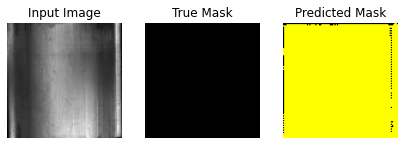

In [ ]:
show_predictions()

#### MODEL 7: TRANSDAUNET
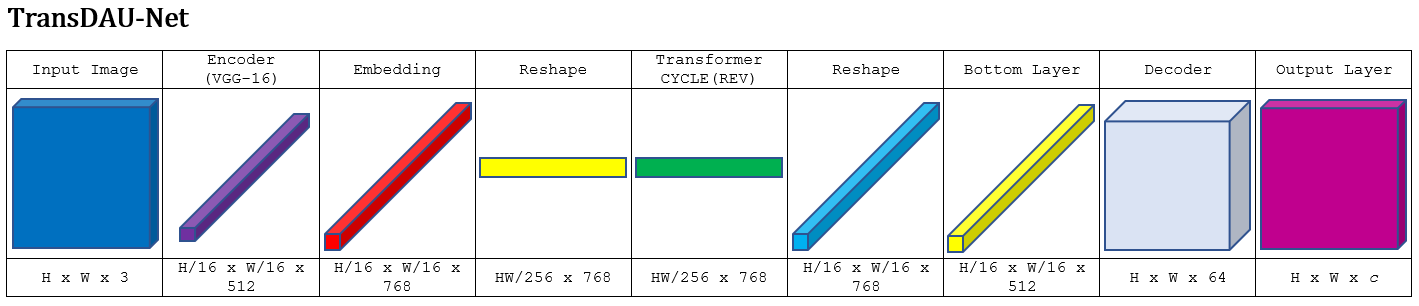

In [ ]:
# contracting part of the architecture
# learn on context information (WHAT)
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
vgg.trainable = False
intermediate = vgg.layers[-2].output

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# trans-encoder part of the architecture
# trans-encoder config params
patch_size = 16
hidden_size = 768
num_attention_heads = 12
num_hidden_layers = 18
encoder_dense = 3072
dropout_rate = 0.1
hh = IMG_HEIGHT // patch_size
ww = IMG_WIDTH // patch_size

# extract patches from hidden features (shape = [B,H/16*W/16,HIDDEN_SIZE])
INPUTDENSE2D_DENSE = Conv2D(filters=hidden_size, kernel_size=1, strides=1, padding="valid", name="embedding", trainable=True)(intermediate)
INPUTDENSE2D_TRANSLAYERNORM = LayerNormalization(epsilon=1e-12, gamma_initializer='ones', beta_initializer='zeros')(INPUTDENSE2D_DENSE)
INPUTDENSE2D_TRANSLAYERNORM = Reshape((INPUTDENSE2D_TRANSLAYERNORM.shape[1] * INPUTDENSE2D_TRANSLAYERNORM.shape[2], hidden_size))(INPUTDENSE2D_TRANSLAYERNORM)

# position embeddings
input_shape = INPUTDENSE2D_TRANSLAYERNORM.shape
seq_length = input_shape[1]
position_ids = tensorflow.range(seq_length)
position_ids = tensorflow.expand_dims(position_ids, 0)
position_ids = tensorflow.broadcast_to(position_ids, tensorflow.shape(INPUTDENSE2D_TRANSLAYERNORM)[:2])

TRANSEMBEDDINGS_POSITION_EMBEDDINGS = Embedding(512+1, hidden_size, input_length=hh*ww, name="PosEmbedLayer")(position_ids)
TRANSEMBEDDINGS_EMBEDDINGS = INPUTDENSE2D_TRANSLAYERNORM + TRANSEMBEDDINGS_POSITION_EMBEDDINGS
TRANSEMBEDDINGS_EMBEDDINGS = LayerNormalization(epsilon=1e-12, gamma_initializer='ones', beta_initializer='zeros', name="EmbedLayerNorm")(TRANSEMBEDDINGS_EMBEDDINGS)
TRANSEMBEDDINGS_EMBEDDINGS = Dropout(dropout_rate, name="EmbedDropLayer")(TRANSEMBEDDINGS_EMBEDDINGS)

# transformer layer
hidden_states = TRANSEMBEDDINGS_EMBEDDINGS
trans_layers = [] 
for i in range(num_hidden_layers//2):
  trans_layers.append(TransformerBlock(
      num_heads=num_attention_heads,
      mlp_dim=encoder_dense,
      dropout=dropout_rate,
      name=f"Transformer/encoderblock_{i}"))
for i in range(num_hidden_layers):
  if (i >= num_hidden_layers//2):
    hidden_states, _ = trans_layers[num_hidden_layers-1-i](hidden_states)
  else:
    hidden_states, _ = trans_layers[i](hidden_states)
    # trans_layers[i].set_weights(vit.get_layer(f"Transformer/encoderblock_{i}").get_weights())
ENCODER_FINAL_DENSE = Dense(hidden_size, activation='gelu', name="FinalDenseLayer")(hidden_states)
ENCODER_FINAL_OUTPUT = Reshape((hh, ww, hidden_size))(ENCODER_FINAL_DENSE)

# bottom block
bottomHead = Conv2D(512, (3,3), activation='relu', padding='same')(ENCODER_FINAL_OUTPUT)
bottomHead = Conv2D(512, (3,3), activation='relu', padding='same', name="BottomBlock")(bottomHead)

In [ ]:
def expend_as(tensor, rep):
    # Anonymous lambda function to expand the specified axis by a factor of argument, rep.
    # If tensor has shape (512,512,N), lambda will return a tensor of shape (512,512,N*rep), if specified axis=2
    my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)
    return my_repeat

In [ ]:
def AttentionNode(x, g, num_channels):
    """Implements an attention module."""
    # vector x is taken from the corresponding downsampling layer in the encoder path
    # vector g is taken from the next lowest layer of the network
    x_shape = x.shape
    g_shape = g.shape

    if (x_shape[1] != g_shape[1] | x_shape[2] != g_shape[2]):
      # Getting the gating signal to the same number of filters as the num_channels
      phi_g = Conv2D(filters=num_channels, kernel_size=1, strides=(1,1), padding='valid')(g)
      # Getting the x signal to the same shape as the gating signal
      theta_x = Conv2D(filters=num_channels, kernel_size=1, strides=(2,2), padding='valid')(x)
    else:
      phi_g = Conv2D(filters=num_channels, kernel_size=1, strides=(1,1), padding='valid')(g)
      theta_x = Conv2D(filters=num_channels, kernel_size=1, strides=(1,1), padding='valid')(x)

    # Element-wise addition of the gating and x signals
    add_xg = Add()([phi_g, theta_x])
    add_xg = ReLU()(add_xg)

    # 1x1x1 convolution
    psi = Conv2D(filters=1, kernel_size=1, padding='same')(add_xg)
    psi = sigmoid(psi)

    if (x_shape[1] != g_shape[1] | x_shape[2] != g_shape[2]):
      # Upsampling psi back to the original dimensions of x signal
      upsample_sigmoid_xg = UpSampling2D(size=(2,2))(psi)
    else:
      upsample_sigmoid_xg = psi

    # Expanding the filter axis to the number of filters in the original x signal
    upsample_sigmoid_xg = expend_as(upsample_sigmoid_xg, x_shape[3])

    # Element-wise multiplication of attention coefficients back onto original x signal
    attn_coefficients = Multiply()([upsample_sigmoid_xg, x])

    # Final 1x1x1 convolution to consolidate attention signal to original x dimensions
    output = Conv2D(filters=x_shape[3]//2, kernel_size=1, strides=1, padding='same')(attn_coefficients)
    output = BatchNormalization()(output)
    return output

In [ ]:
# expansive part of the architecture
# learn on spatial information (WHERE)
# introducing dilated convolutions and soft attention modules into the skip connections
# skip connection 1
# multi-depth dilated inception block 1
# dilated inception block 1: 1st
DILATED_INCEP1_1 = Conv2D(192, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block5_conv3').output)
# dilated inception block 1: 2nd
DILATED_INCEP1_2 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block5_conv3').output)
DILATED_INCEP1_2 = Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_2)
# dilated inception block 1: 3rd
DILATED_INCEP1_3 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block5_conv3').output)
DILATED_INCEP1_3 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_3)
DILATED_INCEP1_3 = Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_3)
# dilated inception block 1: 4th
DILATED_INCEP1_4 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block5_conv3').output)
DILATED_INCEP1_4 = Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_4)
DILATED_INCEP1_4 = Conv2D(128, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_4)
DILATED_INCEP1_4 = Conv2D(192, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_4)
DILATED_1 = Concatenate()([DILATED_INCEP1_1, DILATED_INCEP1_2, DILATED_INCEP1_3, DILATED_INCEP1_4])
# attention modules 1
NON_DILATED_1 = AttentionNode(vgg.get_layer('block5_conv3').output, bottomHead, 512)
DILATED_1 = AttentionNode(DILATED_1, bottomHead, 512)
FIRST_CONN = Concatenate()([NON_DILATED_1, DILATED_1])
# concatenation block 1
FIRST_CONN_BLOCK = Concatenate()([FIRST_CONN, bottomHead])
FIRST_CONN_BLOCK = Conv2D(512, (3,3), activation='relu', padding='same')(FIRST_CONN_BLOCK)
FIRST_CONN_BLOCK = Conv2D(512, (3,3), activation='relu', padding='same')(FIRST_CONN_BLOCK)

In [ ]:
# skip connection 2
# multi-depth dilated inception block 2
# dilated inception block 2: 1st
DILATED_INCEP2_1 = Conv2D(192, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block4_conv3').output)
# dilated inception block 2: 2nd
DILATED_INCEP2_2 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block4_conv3').output)
DILATED_INCEP2_2 = Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_2)
# dilated inception block 2: 3rd
DILATED_INCEP2_3 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block4_conv3').output)
DILATED_INCEP2_3 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_3)
DILATED_INCEP2_3 = Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_3)
# dilated inception block 2: 4th
DILATED_INCEP2_4 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block4_conv3').output)
DILATED_INCEP2_4 = Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_4)
DILATED_INCEP2_4 = Conv2D(128, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_4)
DILATED_INCEP2_4 = Conv2D(192, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_4)
DILATED_2 = Concatenate()([DILATED_INCEP2_1, DILATED_INCEP2_2, DILATED_INCEP2_3, DILATED_INCEP2_4])
# attention modules 2
NON_DILATED_2 = AttentionNode(vgg.get_layer('block4_conv3').output, FIRST_CONN_BLOCK, 512)
DILATED_2 = AttentionNode(DILATED_2, FIRST_CONN_BLOCK, 512)
SECOND_CONN = Concatenate()([NON_DILATED_2, DILATED_2])
# concatenation block 2
SECOND_CONN_BLOCK = pix2pix.upsample(512, 3)(FIRST_CONN_BLOCK)
SECOND_CONN_BLOCK = Concatenate()([SECOND_CONN, SECOND_CONN_BLOCK])
SECOND_CONN_BLOCK = Conv2D(512, (3,3), activation='relu', padding='same')(SECOND_CONN_BLOCK)
SECOND_CONN_BLOCK = Conv2D(512, (3,3), activation='relu', padding='same')(SECOND_CONN_BLOCK)

In [ ]:
# skip connection 3
# multi-depth dilated inception block 3
# dilated inception block 3: 1st
DILATED_INCEP3_1 = Conv2D(96, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block3_conv3').output)
# dilated inception block 3: 2nd
DILATED_INCEP3_2 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block3_conv3').output)
DILATED_INCEP3_2 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_2)
# dilated inception block 3: 3rd
DILATED_INCEP3_3 = Conv2D(8, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block3_conv3').output)
DILATED_INCEP3_3 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_3)
DILATED_INCEP3_3 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_3)
# dilated inception block 3: 4th
DILATED_INCEP3_4 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block3_conv3').output)
DILATED_INCEP3_4 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_4)
DILATED_INCEP3_4 = Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_4)
DILATED_INCEP3_4 = Conv2D(96, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_4)
DILATED_3 = Concatenate()([DILATED_INCEP3_1, DILATED_INCEP3_2, DILATED_INCEP3_3, DILATED_INCEP3_4])
# attention modules 3
NON_DILATED_3 = AttentionNode(vgg.get_layer('block3_conv3').output, SECOND_CONN_BLOCK, 256)
DILATED_3 = AttentionNode(DILATED_3, SECOND_CONN_BLOCK, 256)
THIRD_CONN = Concatenate()([NON_DILATED_3, DILATED_3])
# concatenation block 3
THIRD_CONN_BLOCK = pix2pix.upsample(256, 3)(SECOND_CONN_BLOCK)
THIRD_CONN_BLOCK = Concatenate()([THIRD_CONN, THIRD_CONN_BLOCK])
THIRD_CONN_BLOCK = Conv2D(256, (3,3), activation='relu', padding='same')(THIRD_CONN_BLOCK)
THIRD_CONN_BLOCK = Conv2D(256, (3,3), activation='relu', padding='same')(THIRD_CONN_BLOCK)

In [ ]:
# skip connection 4
# multi-depth dilated inception block 4
# dilated inception block 4: 1st
DILATED_INCEP4_1 = Conv2D(96, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block2_conv2').output)
# dilated inception block 4: 2nd
DILATED_INCEP4_2 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block2_conv2').output)
DILATED_INCEP4_2 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_2)
# dilated inception block 4: 3rd
DILATED_INCEP4_3 = Conv2D(8, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block2_conv2').output)
DILATED_INCEP4_3 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_3)
DILATED_INCEP4_3 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_3)
# dilated inception block 4: 4th
DILATED_INCEP4_4 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block2_conv2').output)
DILATED_INCEP4_4 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_4)
DILATED_INCEP4_4 = Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_4)
DILATED_INCEP4_4 = Conv2D(96, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_4)
DILATED_4 = Concatenate()([DILATED_INCEP4_1, DILATED_INCEP4_2, DILATED_INCEP4_3, DILATED_INCEP4_4])
# attention modules 4
NON_DILATED_4 = AttentionNode(vgg.get_layer('block2_conv2').output, THIRD_CONN_BLOCK, 128)
DILATED_4 = AttentionNode(DILATED_4, THIRD_CONN_BLOCK, 128)
FOURTH_CONN = Concatenate()([NON_DILATED_4, DILATED_4])
# concatenation block 4
FOURTH_CONN_BLOCK = pix2pix.upsample(128, 3)(THIRD_CONN_BLOCK)
FOURTH_CONN_BLOCK = Concatenate()([FOURTH_CONN, FOURTH_CONN_BLOCK])
FOURTH_CONN_BLOCK = Conv2D(128, (3,3), activation='relu', padding='same')(FOURTH_CONN_BLOCK)
FOURTH_CONN_BLOCK = Conv2D(128, (3,3), activation='relu', padding='same')(FOURTH_CONN_BLOCK)

In [ ]:
# skip connection 5
# multi-depth dilated inception block 5
# dilated inception block 5: 1st
DILATED_INCEP5_1 = Conv2D(96, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block1_conv2').output)
# dilated inception block 5: 2nd
DILATED_INCEP5_2 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block1_conv2').output)
DILATED_INCEP5_2 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_2)
# dilated inception block 5: 3rd
DILATED_INCEP5_3 = Conv2D(8, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block1_conv2').output)
DILATED_INCEP5_3 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_3)
DILATED_INCEP5_3 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_3)
# dilated inception block 5: 4th
DILATED_INCEP5_4 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block1_conv2').output)
DILATED_INCEP5_4 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_4)
DILATED_INCEP5_4 = Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_4)
DILATED_INCEP5_4 = Conv2D(96, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_4)
DILATED_5 = Concatenate()([DILATED_INCEP5_1, DILATED_INCEP5_2, DILATED_INCEP5_3, DILATED_INCEP5_4])
# attention modules 5
NON_DILATED_5 = AttentionNode(vgg.get_layer('block1_conv2').output, FOURTH_CONN_BLOCK, 64)
DILATED_5 = AttentionNode(DILATED_5, FOURTH_CONN_BLOCK, 64)
FIFTH_CONN = Concatenate()([NON_DILATED_5, DILATED_5])
# concatenation block 5
FIFTH_CONN_BLOCK = pix2pix.upsample(64, 3)(FOURTH_CONN_BLOCK)
FIFTH_CONN_BLOCK = Concatenate()([FIFTH_CONN, FIFTH_CONN_BLOCK])
FIFTH_CONN_BLOCK = Conv2D(64, (3,3), activation='relu', padding='same')(FIFTH_CONN_BLOCK)
FIFTH_CONN_BLOCK = Conv2D(64, (3,3), activation='relu', padding='same')(FIFTH_CONN_BLOCK)

In [ ]:
maskHead = Conv2D(len(lb.classes_), (1, 1), activation="softmax", name="mask")(FIFTH_CONN_BLOCK)

# put together our model which accept an input image and then output segmentation mask
model = Model(
    inputs=vgg.input,
    outputs=maskHead)

In [ ]:
# initialize the optimizer, compile the model, and show the model summary
losses = {
    "mask": "sparse_categorical_crossentropy",
}

# assign a higher weight as the cross-entropy loss might be as low as 0.1
lossWeights = {
    "mask": 10.0,
}

# initialize the optimizer, compile the model, and show the model summary
# opt = Adam(INIT_LR)
opt = tfa.optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
model.compile(loss=losses, optimizer=opt, metrics=[mean_iou(num_classes=len(lb.classes_))], loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 96, 96, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 96, 96, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 48, 48, 64)   0           ['block1_conv2[0][0]']           
                                                                                              

In [ ]:
tensorflow.keras.utils.plot_model(model, show_shapes=True)

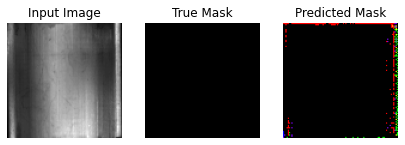

In [ ]:
show_predictions()

## CHAPTER 4: MODEL TRAINING

In [ ]:
# visualize the changes in predicted mask output for every epoch
from IPython.display import clear_output
class DisplayCallback(tensorflow.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    # clear_output(wait=True)
    # show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
import tensorflow.keras.callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_filepath = 'model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_loss",
    mode='min',
    save_weights_only=False,
    save_best_only=True 
    )

In [ ]:
# model training
VAL_SUBSPLITS = 5
print("[INFO] training model...")
H = model.fit(
    train_generator,
    steps_per_epoch=len(train_images)//BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=len(val_images)//BATCH_SIZE//VAL_SUBSPLITS,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[DisplayCallback(), model_checkpoint_callback])

[INFO] training model...
Epoch 1/50
1560/1560 [==============================] - ETA: 0s - loss: 0.1784 - mean_iou: 0.2471
Sample Prediction after epoch 1

1560/1560 [==============================] - 516s 288ms/step - loss: 0.1784 - mean_iou: 0.2471 - val_loss: 1.7242 - val_mean_iou: 0.4028
Epoch 2/50
1560/1560 [==============================] - ETA: 0s - loss: 0.0808 - mean_iou: 0.4996
Sample Prediction after epoch 2

1560/1560 [==============================] - 451s 289ms/step - loss: 0.0808 - mean_iou: 0.4996 - val_loss: 1.5539 - val_mean_iou: 0.5628
Epoch 3/50
1560/1560 [==============================] - ETA: 0s - loss: 0.0508 - mean_iou: 0.6079
Sample Prediction after epoch 3

1560/1560 [==============================] - 450s 288ms/step - loss: 0.0508 - mean_iou: 0.6079 - val_loss: 0.7496 - val_mean_iou: 0.6351
Epoch 4/50
1560/1560 [==============================] - ETA: 0s - loss: 0.0365 - mean_iou: 0.6689
Sample Prediction after epoch 4

1560/1560 [=============================

In [ ]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save("model", save_format="tf")

## CHAPTER 5: MODEL EVALUATION


#### CONFUSION MATRIX (CM)

In [ ]:
# Confusion Matrix (CM)
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

def plot_confusion_matrix(m, title='Confusion matrix'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    cmap = ListedColormap([[1, 1, 1]])
    img = ax.matshow(m, cmap=cmap)
    plt.title(title)
    
    for (i, j), z in np.ndenumerate(m):
        ax.text(j, i, '{:.0f}'.format(z), ha='center', va='center')
    
    tick_marks = np.arange(6)
    plt.xticks(tick_marks, lb.classes_)
    plt.yticks(tick_marks, lb.classes_)
    plt.ylabel('GROUND TRUTH')
    plt.xlabel('PREDICTED')

#### TP/FP/TN/FN & PIXEL ACCURACY (PA) & DICE & INTERSECTION OVER UNION (IoU)

In [ ]:
# TP/FP/TN/FN & Pixel Accuracy (PA) & Intersection Over Union (IoU) & Dice Score
def TP_TN_FP_FN_PA_IOU_DICE(confusion_m, model_name, l=len(lb.classes_)):
    TP = np.zeros((len(model_name), l))
    TN = np.zeros((len(model_name), l))
    FP = np.zeros((len(model_name), l))
    FN = np.zeros((len(model_name), l))
    
    for index, cm in enumerate(confusion_m):
        TP[index] = np.diag(cm)
        
        for i in range(l):
            temp = np.delete(cm, i, 0)   # delete ith row
            temp = np.delete(temp, i, 1)  # delete ith column
            TN[index][i] = sum(sum(temp))

        for i in range(l):
            FP[index][i] = sum(cm[:,i]) - cm[i,i]

        for i in range(l):
            FN[index][i] = sum(cm[i,:]) - cm[i,i]

    # print('                         | ' + model_name[0] + '\t\t\t| ' + model_name[1] + '\t\t\t| ' + model_name[2] + '\t\t\t| ' + model_name[3] + '\t\t| ' + model_name[4] + '\t\t\t| ' + model_name[5] + '\t\t| ' + model_name[6])
    print('                         | ' + model_name[0] + '\t\t\t| ' + model_name[1] + '\t\t| ' + model_name[2] + '\t\t\t| ' + model_name[3] + '\t\t| ' + model_name[4])
    print("*************************|" + '**********************|***********************|***********************|***********************|***********************')
    for i in range(l):
        # print("True Positive \t\t |", "{:.2f}".format(TP[0][i]), '\t\t|', "{:.2f}".format(TP[1][i]), '\t\t|', "{:.2f}".format(TP[2][i]), '\t\t|', "{:.2f}".format(TP[3][i]), '\t\t|', "{:.2f}".format(TP[4][i]), '\t\t|', "{:.2f}".format(TP[5][i]), '\t\t|', "{:.2f}".format(TP[6][i]))
        # print("True Negative \t\t |", "{:.2f}".format(TN[0][i]), '\t\t|', "{:.2f}".format(TN[1][i]), '\t\t|', "{:.2f}".format(TN[2][i]), '\t\t|', "{:.2f}".format(TN[3][i]), '\t\t|', "{:.2f}".format(TN[4][i]), '\t\t|', "{:.2f}".format(TN[5][i]), '\t\t|', "{:.2f}".format(TN[6][i]))
        # print("False Positive \t\t |", "{:.2f}".format(FP[0][i]), '\t\t|', "{:.2f}".format(FP[1][i]), '\t\t|', "{:.2f}".format(FP[2][i]), '\t\t|', "{:.2f}".format(FP[3][i]), '\t\t|', "{:.2f}".format(FP[4][i]), '\t\t|', "{:.2f}".format(FP[5][i]), '\t\t|', "{:.2f}".format(FP[6][i]))
        # print("False Negative \t\t |", "{:.2f}".format(FN[0][i]), '\t\t|', "{:.2f}".format(FN[1][i]), '\t\t|', "{:.2f}".format(FN[2][i]), '\t\t|', "{:.2f}".format(FN[3][i]), '\t\t|', "{:.2f}".format(FN[4][i]), '\t\t|', "{:.2f}".format(FN[5][i]), '\t\t|', "{:.2f}".format(FN[6][i]))
        print("True Positive \t\t |", "{:.2f}".format(TP[0][i]), '\t\t|', "{:.2f}".format(TP[1][i]), '\t\t|', "{:.2f}".format(TP[2][i]), '\t\t|', "{:.2f}".format(TP[3][i]), '\t\t|', "{:.2f}".format(TP[4][i]))
        print("True Negative \t\t |", "{:.2f}".format(TN[0][i]), '\t\t|', "{:.2f}".format(TN[1][i]), '\t\t|', "{:.2f}".format(TN[2][i]), '\t\t|', "{:.2f}".format(TN[3][i]), '\t\t|', "{:.2f}".format(TN[4][i]))
        print("False Positive \t\t |", "{:.2f}".format(FP[0][i]), '\t\t|', "{:.2f}".format(FP[1][i]), '\t\t|', "{:.2f}".format(FP[2][i]), '\t\t|', "{:.2f}".format(FP[3][i]), '\t\t|', "{:.2f}".format(FP[4][i]))
        print("False Negative \t\t |", "{:.2f}".format(FN[0][i]), '\t\t|', "{:.2f}".format(FN[1][i]), '\t\t|', "{:.2f}".format(FN[2][i]), '\t\t|', "{:.2f}".format(FN[3][i]), '\t\t|', "{:.2f}".format(FN[4][i]))
        print("Precision Rate \t\t |", 
             "{:.2f}".format(TP[0][i] / (TP[0][i] + FP[0][i])*100), '\t\t|', 
             "{:.2f}".format(TP[1][i] / (TP[1][i] + FP[1][i])*100), '\t\t|',
             "{:.2f}".format(TP[2][i] / (TP[2][i] + FP[2][i])*100), '\t\t|',
             "{:.2f}".format(TP[3][i] / (TP[3][i] + FP[3][i])*100), '\t\t|',
             "{:.2f}".format(TP[4][i] / (TP[4][i] + FP[4][i])*100))
            #  "{:.2f}".format(TP[4][i] / (TP[4][i] + FP[4][i])*100), '\t\t|',
            #  "{:.2f}".format(TP[5][i] / (TP[5][i] + FP[5][i])*100), '\t\t|',
            #  "{:.2f}".format(TP[6][i] / (TP[6][i] + FP[6][i])*100))
        print("Recall Rate \t\t |", 
             "{:.2f}".format(TP[0][i] / (TP[0][i] + FN[0][i])*100), '\t\t|', 
             "{:.2f}".format(TP[1][i] / (TP[1][i] + FN[1][i])*100), '\t\t|',
             "{:.2f}".format(TP[2][i] / (TP[2][i] + FN[2][i])*100), '\t\t|',
             "{:.2f}".format(TP[3][i] / (TP[3][i] + FN[3][i])*100), '\t\t|',
             "{:.2f}".format(TP[4][i] / (TP[4][i] + FN[4][i])*100))
            #  "{:.2f}".format(TP[4][i] / (TP[4][i] + FN[4][i])*100), '\t\t|',
            #  "{:.2f}".format(TP[5][i] / (TP[5][i] + FN[5][i])*100), '\t\t|',
            #  "{:.2f}".format(TP[6][i] / (TP[6][i] + FN[6][i])*100))
        print("Pixel Accuracy \t\t |", 
             "{:.2f}".format((TP[0][i] + TN[0][i]) / (TP[0][i] + TN[0][i] + FP[0][i] + FN[0][i])*100), '\t\t|', 
             "{:.2f}".format((TP[1][i] + TN[1][i]) / (TP[1][i] + TN[1][i] + FP[1][i] + FN[1][i])*100), '\t\t|',
             "{:.2f}".format((TP[2][i] + TN[2][i]) / (TP[2][i] + TN[2][i] + FP[2][i] + FN[2][i])*100), '\t\t|',
             "{:.2f}".format((TP[3][i] + TN[3][i]) / (TP[3][i] + TN[3][i] + FP[3][i] + FN[3][i])*100), '\t\t|',
             "{:.2f}".format((TP[4][i] + TN[4][i]) / (TP[4][i] + TN[4][i] + FP[4][i] + FN[4][i])*100))
            #  "{:.2f}".format((TP[4][i] + TN[4][i]) / (TP[4][i] + TN[4][i] + FP[4][i] + FN[4][i])*100), '\t\t|',
            #  "{:.2f}".format((TP[5][i] + TN[5][i]) / (TP[5][i] + TN[5][i] + FP[5][i] + FN[5][i])*100), '\t\t|',
            #  "{:.2f}".format((TP[6][i] + TN[6][i]) / (TP[6][i] + TN[6][i] + FP[6][i] + FN[6][i])*100))
        print("Intersection Over Union  |", 
             "{:.2f}".format((TP[0][i]) / (TP[0][i] + FP[0][i] + FN[0][i])*100), '\t\t|', 
             "{:.2f}".format((TP[1][i]) / (TP[1][i] + FP[1][i] + FN[1][i])*100), '\t\t|',
             "{:.2f}".format((TP[2][i]) / (TP[2][i] + FP[2][i] + FN[2][i])*100), '\t\t|',
             "{:.2f}".format((TP[3][i]) / (TP[3][i] + FP[3][i] + FN[3][i])*100), '\t\t|',
             "{:.2f}".format((TP[4][i]) / (TP[4][i] + FP[4][i] + FN[4][i])*100))
            #  "{:.2f}".format((TP[4][i]) / (TP[4][i] + FP[4][i] + FN[4][i])*100), '\t\t|',
            #  "{:.2f}".format((TP[5][i]) / (TP[5][i] + FP[5][i] + FN[5][i])*100), '\t\t|',
            #  "{:.2f}".format((TP[6][i]) / (TP[6][i] + FP[6][i] + FN[6][i])*100))
        print("Dice Score \t\t |", 
             "{:.2f}".format((2*TP[0][i]) / (2*TP[0][i] + FP[0][i] + FN[0][i])*100), '\t\t|', 
             "{:.2f}".format((2*TP[1][i]) / (2*TP[1][i] + FP[1][i] + FN[1][i])*100), '\t\t|',
             "{:.2f}".format((2*TP[2][i]) / (2*TP[2][i] + FP[2][i] + FN[2][i])*100), '\t\t|',
             "{:.2f}".format((2*TP[3][i]) / (2*TP[3][i] + FP[3][i] + FN[3][i])*100), '\t\t|',
             "{:.2f}".format((2*TP[4][i]) / (2*TP[4][i] + FP[4][i] + FN[4][i])*100))
            #  "{:.2f}".format((2*TP[4][i]) / (2*TP[4][i] + FP[4][i] + FN[4][i])*100), '\t\t|',
            #  "{:.2f}".format((2*TP[5][i]) / (2*TP[5][i] + FP[5][i] + FN[5][i])*100), '\t\t|',
            #  "{:.2f}".format((2*TP[6][i]) / (2*TP[6][i] + FP[6][i] + FN[6][i])*100))
        print('------------------------------------------------------------------------------------------------------------------------------------------------')
    print('************************************************************************************************************************************************')

#### MEAN INTERSECTION OVER UNION (IoU)

In [ ]:
from tensorflow.keras.metrics import MeanIoU
def mean_IOU(y_true, y_pred, smooth=0.001):
    #             ∥ A ∩ B ∥ 
    # IoU(A,B)  = --------- 
    #             ∥ A ∪ B ∥
    
    #               2 ∥ A ∩ B ∥ 
    # Dice(A,B) = -------------
    #             ∥ A ∥ + ∥ B ∥ 
    
    m = MeanIoU(num_classes=len(lb.classes_))
    m.update_state(y_true, y_pred)
    mean_iou = m.result().numpy()
    
    return mean_iou
    
#     axes = (1,2) # W,H axes of each image
#     intersection = np.sum(np.logical_and(y_pred, y_true), axis=axes) # A ∩ B 
#     union = np.sum(np.logical_or(y_pred, y_true), axis=axes) # A ∪ B
#     mask_sum = np.sum(np.abs(y_true), axis=axes) + np.sum(np.abs(y_pred), axis=axes) # ∥ A ∥ + ∥ B ∥

#     smooth = .001 # avoid intersection/union = 0/0 = nan
#     iou = (intersection + smooth) / (union + smooth)
#     dice = 2 * (intersection + smooth) / (mask_sum + smooth)
    
#     average_iou_score = np.mean(iou)
#     average_dice_score = np.mean(dice)
    
#     return average_iou_score
#     return average_iou_score, average_dice_score

#### PR CURVE

In [ ]:
# Precision-Recall Curve (PR)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

def plot_PR_curve(y_true, y_pred, name):
    
    precision = []
    recall = []
    average_precision = []
    plots = []
    for index in range(len(y_pred)):
        precision.append(dict())
        recall.append(dict())
        average_precision.append(dict())

        for i in range(len(lb.classes_)):
            precision[index][i], recall[index][i], _ = precision_recall_curve(y_true[:, i], y_pred[index][:, i])
            average_precision[index][i] = average_precision_score(y_true[:, i], y_pred[index][:, i])

        # A "micro-average": quantifying score on all classes jointly
        precision[index]["micro"], recall[index]["micro"], _ = precision_recall_curve(y_true.ravel(), y_pred[index].ravel())
        average_precision[index]["micro"] = average_precision_score(y_true, y_pred[index], average="micro")

        plots.append(PrecisionRecallDisplay(
            recall=recall[index]["micro"],
            precision=precision[index]["micro"],
            average_precision=average_precision[index]["micro"],
        ))

    for index in range(len(plots)):
        plots[index].plot(name=name[index], ax=plt.gca())
        _ = plots[index].ax_.set_title("Micro-averaged over all classes")

#### ROC CURVE

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred, name):
    truth = y_true.ravel()
    score = []
    fpr = []
    tpr = []
    roc_auc = []
    for index in range(len(y_pred)):
        score.append(y_pred[index].ravel()) # we want to make them into vectors
        f, t, _ = roc_curve(truth, score[index])
        fpr.append(f)
        tpr.append(t)
        roc_auc.append(auc(fpr[index], tpr[index]))
    
    fig, ax = plt.subplots(1, 1)
    for index in range(len(y_pred)):
        ax.plot(fpr[index], tpr[index], label = name[index] + ' ROC curve (area = %0.2f)' % roc_auc[index])
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Receiver operating characteristic example')
        ax.legend(loc="lower right")

#### DISPLAY PREDICTION SAMPLE

In [ ]:
def show_prediction_sample(img, label, predict, length=15):
    for i in range(length):
        display([img[i], label[i], predict[i]])

#### ... START EVALUATION ON VALIDATION SET ...

In [ ]:
# load models
from tensorflow.keras.models import load_model
# FCN = load_model("SEMANTIC_SEGMENTATION_MAGNETIC_TILE_FCN.h5")
# DNET = load_model("SEMANTIC_SEGMENTATION_MAGNETIC_TILE_DILATEDNET.h5")
UNET = load_model("SEMANTIC_SEGMENTATION_MAGNETIC_TILE_VGGUNET.h5")
# DDUNET = load_model("SEMANTIC_SEGMENTATION_MAGNETIC_TILE_DOUBLEUNET.h5")
MDDUNET = load_model("SEMANTIC_SEGMENTATION_MAGNETIC_TILE_DOUBLEDILATEDUNET.h5")
SETR = load_model('SEMANTIC_SEGMENTATION_MAGNETIC_TILE_SETR.h5', 
                  custom_objects={'MultiHeadSelfAttention': MultiHeadSelfAttention, 
                                  'TransformerBlock': TransformerBlock,
                                  'AdamW': tfa.optimizers.AdamW,
                                  'mean_iou': mean_iou})
TRANSUNET = load_model('SEMANTIC_SEGMENTATION_MAGNETIC_TILE_TRANSUNET.h5', 
                       custom_objects={'MultiHeadSelfAttention': MultiHeadSelfAttention, 
                                       'TransformerBlock': TransformerBlock,
                                       'AdamW': tfa.optimizers.AdamW,
                                       'mean_iou': mean_iou})
TRANSDAUNET = load_model('SEMANTIC_SEGMENTATION_MAGNETIC_TILE_TRANSDAUNET.h5', 
                         custom_objects={'MultiHeadSelfAttention': MultiHeadSelfAttention, 
                                         'TransformerBlock': TransformerBlock,
                                         'AdamW': tfa.optimizers.AdamW,
                                         'mean_iou': mean_iou})

In [ ]:
import random
random.seed(1)
r = random.sample(range(0, 7800), 100)
train_samples_img = train_images[r]
train_samples_label = train_labels_iou[r]

In [ ]:
# Ground Truth vs Models Prediction
y_true_train = val_labels_iou
y_true_train_flatten = y_true_train.flatten().astype('int')

# y_pred_train_FCN = np.argmax(FCN.predict(val_images), axis=3)
# y_pred_train_DNET = np.argmax(DNET.predict(val_images), axis=3)
y_pred_train_UNET = np.argmax(UNET.predict(val_images), axis=3)
# y_pred_train_DDUNET = np.argmax(DDUNET.predict(val_images), axis=3)
y_pred_train_MDDUNET = np.argmax(MDDUNET.predict(val_images), axis=3)
y_pred_train_SETR = np.argmax(SETR.predict(val_images), axis=3)
y_pred_train_TRANSUNET = np.argmax(TRANSUNET.predict(val_images), axis=3)
y_pred_train_TRANSDAUNET = np.argmax(TRANSDAUNET.predict(val_images), axis=3)

# y_pred_train_FCN_flatten = y_pred_train_FCN.flatten().astype('int')
# y_pred_train_DNET_flatten = y_pred_train_DNET.flatten().astype('int')
y_pred_train_UNET_flatten = y_pred_train_UNET.flatten().astype('int')
# y_pred_train_DDUNET_flatten = y_pred_train_DDUNET.flatten().astype('int')
y_pred_train_MDDUNET_flatten = y_pred_train_MDDUNET.flatten().astype('int')
y_pred_train_SETR_flatten = y_pred_train_SETR.flatten().astype('int')
y_pred_train_TRANSUNET_flatten = y_pred_train_TRANSUNET.flatten().astype('int')
y_pred_train_TRANSDAUNET_flatten = y_pred_train_TRANSDAUNET.flatten().astype('int')

# y_pred_train_FCN_mask = y_pred_train_FCN.flatten().astype('int').reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
# y_pred_train_DNET_mask = y_pred_train_DNET.flatten().astype('int').reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
y_pred_train_UNET_mask = y_pred_train_UNET.flatten().astype('int').reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
# y_pred_train_DDUNET_mask = y_pred_train_DDUNET.flatten().astype('int').reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
y_pred_train_MDDUNET_mask = y_pred_train_MDDUNET.flatten().astype('int').reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
y_pred_train_SETR_mask = y_pred_train_SETR.flatten().astype('int').reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
y_pred_train_TRANSUNET_mask = y_pred_train_TRANSUNET.flatten().astype('int').reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
y_pred_train_TRANSDAUNET_mask = y_pred_train_TRANSDAUNET.flatten().astype('int').reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)

In [ ]:
# generate confusion_matrix
# FCN_train_cm = confusion_matrix(y_true_train_flatten, y_pred_train_FCN_flatten)
# DNET_train_cm = confusion_matrix(y_true_train_flatten, y_pred_train_DNET_flatten)
UNET_train_cm = confusion_matrix(y_true_train_flatten, y_pred_train_UNET_flatten)
# DDUNET_train_cm = confusion_matrix(y_true_train_flatten, y_pred_train_DDUNET_flatten)
MDDUNET_train_cm = confusion_matrix(y_true_train_flatten, y_pred_train_MDDUNET_flatten)
SETR_train_cm = confusion_matrix(y_true_train_flatten, y_pred_train_SETR_flatten)
TRANSUNET_train_cm = confusion_matrix(y_true_train_flatten, y_pred_train_TRANSUNET_flatten)
TRANSDAUNET_train_cm = confusion_matrix(y_true_train_flatten, y_pred_train_TRANSDAUNET_flatten)

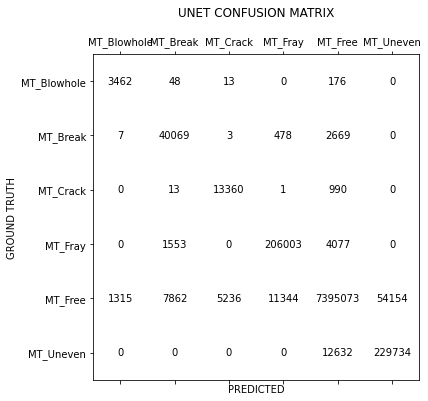

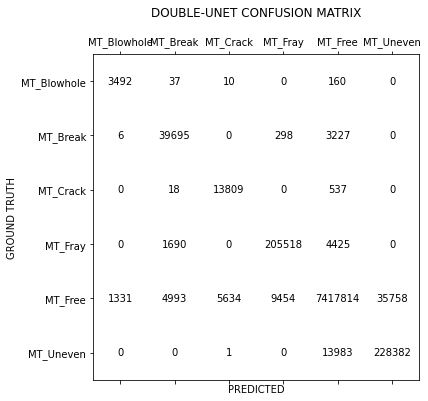

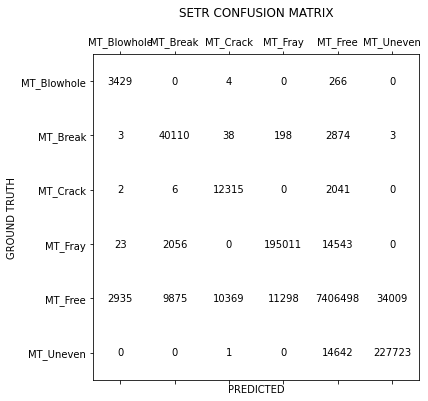

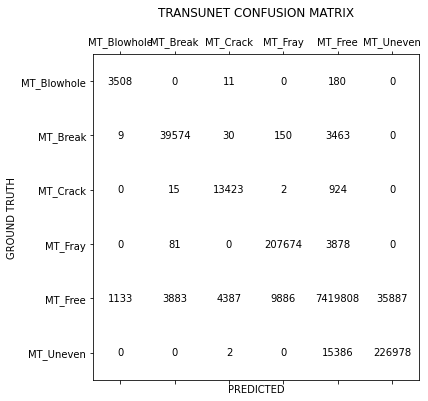

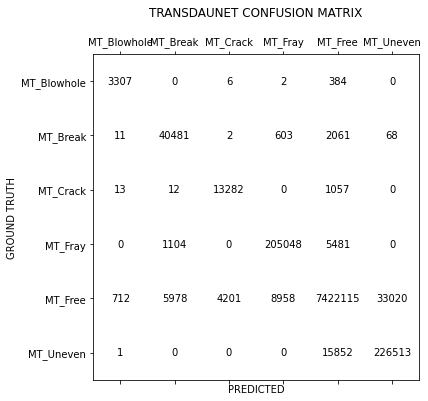

In [ ]:
# CM
# plot_confusion_matrix(FCN_train_cm, title='FCN CONFUSION MATRIX\n')
# plot_confusion_matrix(DNET_train_cm, title='DILATEDNET CONFUSION MATRIX\n')
plot_confusion_matrix(UNET_train_cm, title='UNET CONFUSION MATRIX\n')
# plot_confusion_matrix(DDUNET_train_cm, title='DOUBLE-UNET CONFUSION MATRIX\n')
plot_confusion_matrix(MDDUNET_train_cm, title='DOUBLE-UNET CONFUSION MATRIX\n')
plot_confusion_matrix(SETR_train_cm, title='SETR CONFUSION MATRIX\n')
plot_confusion_matrix(TRANSUNET_train_cm, title='TRANSUNET CONFUSION MATRIX\n')
plot_confusion_matrix(TRANSDAUNET_train_cm, title='TRANSDAUNET CONFUSION MATRIX\n')

In [ ]:
# PA_IOU
# TP_TN_FP_FN_PA_IOU_DICE([FCN_train_cm, DNET_train_cm, UNET_train_cm, MDDUNET_train_cm, SETR_train_cm, TRANSUNET_train_cm, TRANSDAUNET_train_cm], ["FCN", "DNET", "UNET", "DOUBLEUNET", "SETR", "TRANSUNET", "TRANSDAUNET"])
TP_TN_FP_FN_PA_IOU_DICE([UNET_train_cm, MDDUNET_train_cm, SETR_train_cm, TRANSUNET_train_cm, TRANSDAUNET_train_cm], ["UNET", "DOUBLEUNET", "SETR", "TRANSUNET", "TRANSDAUNET"])

                         | UNET			| DOUBLEUNET		| SETR			| TRANSUNET		| TRANSDAUNET
*************************|**********************|***********************|***********************|***********************|***********************
True Positive 		 | 3462.00 		| 3492.00 		| 3429.00 		| 3508.00 		| 3307.00
True Negative 		 | 7985251.00 		| 7985236.00 		| 7983610.00 		| 7985431.00 		| 7985836.00
False Positive 		 | 1322.00 		| 1337.00 		| 2963.00 		| 1142.00 		| 737.00
False Negative 		 | 237.00 		| 207.00 		| 270.00 		| 191.00 		| 392.00
Precision Rate 		 | 72.37 		| 72.31 		| 53.65 		| 75.44 		| 81.78
Recall Rate 		 | 93.59 		| 94.40 		| 92.70 		| 94.84 		| 89.40
Pixel Accuracy 		 | 99.98 		| 99.98 		| 99.96 		| 99.98 		| 99.99
Intersection Over Union  | 68.95 		| 69.34 		| 51.47 		| 72.46 		| 74.55
Dice Score 		 | 81.62 		| 81.89 		| 67.96 		| 84.03 		| 85.42
----------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# IoU_score_train_FCN, dice_score_train_FCN = DICE_IOU(y_true_train, y_pred_train_FCN_mask)
# IoU_score_train_UNET, dice_score_train_UNET = DICE_IOU(y_true_train, y_pred_train_UNET_mask)
# IoU_score_train_DNET, dice_score_train_DNET = DICE_IOU(y_true_train, y_pred_train_DNET_mask)
# IoU_score_train_DDUNET, dice_score_train_DDUNET = DICE_IOU(y_true_train, y_pred_train_DDUNET_mask)
# mean_IoU_score_train_FCN = mean_IOU(y_true_train_flatten, y_pred_train_FCN_flatten)
mean_IoU_score_train_UNET = mean_IOU(y_true_train_flatten, y_pred_train_UNET_flatten)
# mean_IoU_score_train_DNET = mean_IOU(y_true_train_flatten, y_pred_train_DNET_flatten)
# mean_IoU_score_train_DDUNET = mean_IOU(y_true_train_flatten, y_pred_train_DDUNET_flatten)
mean_IoU_score_train_MDDUNET = mean_IOU(y_true_train_flatten, y_pred_train_MDDUNET_flatten)
mean_IoU_score_train_SETR = mean_IOU(y_true_train_flatten, y_pred_train_SETR_flatten)
mean_IoU_score_train_TRANSUNET = mean_IOU(y_true_train_flatten, y_pred_train_TRANSUNET_flatten)
mean_IoU_score_train_TRANSDAUNET = mean_IOU(y_true_train_flatten, y_pred_train_TRANSDAUNET_flatten)

# print('                         | ' + "FCN" + '\t\t | ' + "DNET" + '\t\t | ' + "UNET" + '\t\t | ' + "DOUBLEUNET" + '\t | ' + "SETR" + '\t\t | ' + "TRANSUNET" + '\t | ' + "TRANSDAUNET")
print('                         | ' + "UNET" + '\t\t | ' + "DOUBLEUNET" + '\t | ' + "SETR" + '\t\t | ' + "TRANSUNET" + '\t | ' + "TRANSDAUNET")
print("*************************|" + '***************|***************|***************|***************|***************')
print("Intersection over Union :| " + 
    #  "{:.2f}".format(mean_IoU_score_train_FCN*100) + "\t | " + 
    #  "{:.2f}".format(mean_IoU_score_train_DNET*100) + "\t | " +
     "{:.2f}".format(mean_IoU_score_train_UNET*100) + "\t | " +
     # "{:.2f}".format(mean_IoU_score_train_DDUNET*100) + "\t | " +
     "{:.2f}".format(mean_IoU_score_train_MDDUNET*100) + "\t | " +
     "{:.2f}".format(mean_IoU_score_train_SETR*100) + "\t | " +
     "{:.2f}".format(mean_IoU_score_train_TRANSUNET*100) + "\t | " +
     "{:.2f}".format(mean_IoU_score_train_TRANSDAUNET*100))
print("*************************|" + '***************|***************|***************|***************|***************')

                         | UNET		 | DOUBLEUNET	 | SETR		 | TRANSUNET	 | TRANSDAUNET
*************************|***************|***************|***************|***************|***************
Intersection over Union :| 80.24	 | 81.95	 | 73.72	 | 83.65	 | 83.40
*************************|***************|***************|***************|***************|***************


In [ ]:
# from sklearn.preprocessing import label_binarize
# y_true_train = label_binarize(y_true_train_flatten, classes=[*range(len(lb.classes_))])
# y_pred_train_FCN = label_binarize(y_pred_train_FCN_flatten, classes=[*range(len(lb.classes_))])
# y_pred_train_UNET = label_binarize(y_pred_train_UNET_flatten, classes=[*range(len(lb.classes_))])
# y_pred_train_DNET = label_binarize(y_pred_train_DNET_flatten, classes=[*range(len(lb.classes_))])
# y_pred_train_DDUNET = label_binarize(y_pred_train_DDUNET_flatten, classes=[*range(len(lb.classes_))])

# plot_PR_curve(y_true_train, [y_pred_train_FCN, y_pred_train_UNET, y_pred_train_DNET, y_pred_train_DDUNET], ["FCN", "UNET", "DNET", "DOUBLEUNET"])

In [ ]:
# plot_roc_curve(y_true_train, [y_pred_train_FCN, y_pred_train_UNET, y_pred_train_DNET, y_pred_train_DDUNET], ["FCN", "UNET", "DNET", "DOUBLEUNET"])

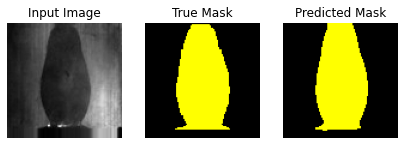

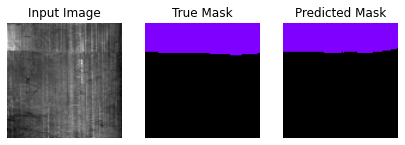

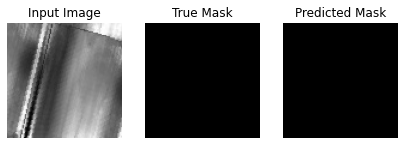

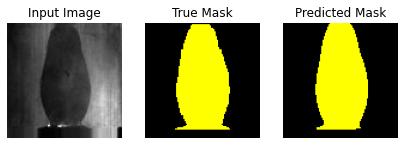

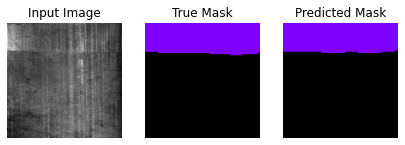

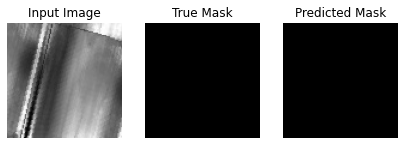

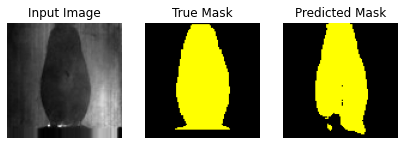

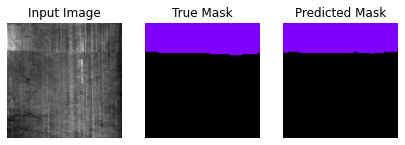

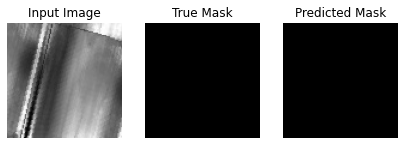

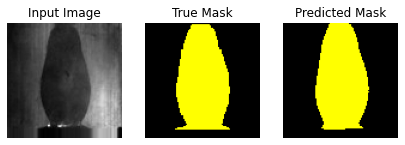

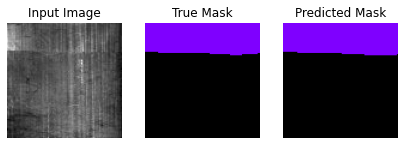

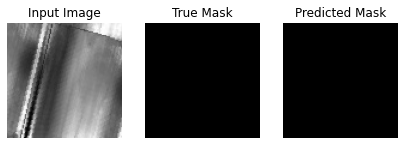

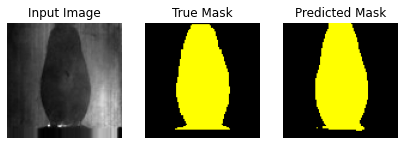

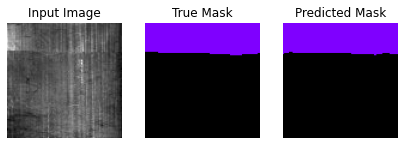

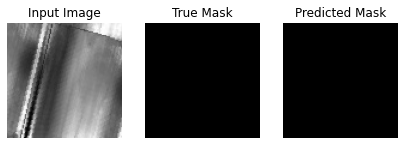

In [ ]:
# display some predictions
import random
random.seed(1)
l = 3
r = random.sample(range(0, 100), l)
# show_prediction_sample(val_images[r], val_labels_iou[r], y_pred_train_FCN_mask[r], l)
# show_prediction_sample(val_images[r], val_labels_iou[r], y_pred_train_DNET_mask[r], l)
show_prediction_sample(val_images[r], val_labels_iou[r], y_pred_train_UNET_mask[r], l)
# show_prediction_sample(val_images[r], val_labels_iou[r], y_pred_train_DDUNET_mask[r], l)
show_prediction_sample(val_images[r], val_labels_iou[r], y_pred_train_MDDUNET_mask[r], l)
show_prediction_sample(val_images[r], val_labels_iou[r], y_pred_train_SETR_mask[r], l)
show_prediction_sample(val_images[r], val_labels_iou[r], y_pred_train_TRANSUNET_mask[r], l)
show_prediction_sample(val_images[r], val_labels_iou[r], y_pred_train_TRANSDAUNET_mask[r], l)

## CHAPTER 6: MODEL TESTING

In [ ]:
# Ground Truth vs Models Prediction
y_true_test = test_labels_iou
y_true_test_flatten = y_true_test.flatten().astype('int')

# y_pred_test_FCN = np.argmax(FCN.predict(test_images), axis=3)
# y_pred_test_DNET = np.argmax(DNET.predict(test_images), axis=3)
y_pred_test_UNET = np.argmax(UNET.predict(test_images), axis=3)
# y_pred_test_DDUNET = np.argmax(DDUNET.predict(test_images), axis=3)
y_pred_test_MDDUNET = np.argmax(MDDUNET.predict(test_images), axis=3)
y_pred_test_SETR = np.argmax(SETR.predict(test_images), axis=3)
y_pred_test_TRANSUNET = np.argmax(TRANSUNET.predict(test_images), axis=3)
y_pred_test_TRANSDAUNET = np.argmax(TRANSDAUNET.predict(test_images), axis=3)

# y_pred_test_FCN_flatten = y_pred_test_FCN.flatten().astype('int')
# y_pred_test_DNET_flatten = y_pred_test_DNET.flatten().astype('int')
y_pred_test_UNET_flatten = y_pred_test_UNET.flatten().astype('int')
# y_pred_test_DDUNET_flatten = y_pred_test_DDUNET.flatten().astype('int')
y_pred_test_MDDUNET_flatten = y_pred_test_MDDUNET.flatten().astype('int')
y_pred_test_SETR_flatten = y_pred_test_SETR.flatten().astype('int')
y_pred_test_TRANSUNET_flatten = y_pred_test_TRANSUNET.flatten().astype('int')
y_pred_test_TRANSDAUNET_flatten = y_pred_test_TRANSDAUNET.flatten().astype('int')

# y_pred_test_FCN_mask = y_pred_test_FCN.flatten().astype('int').reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
# y_pred_test_DNET_mask = y_pred_test_DNET.flatten().astype('int').reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
y_pred_test_UNET_mask = y_pred_test_UNET.flatten().astype('int').reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
# y_pred_test_DDUNET_mask = y_pred_test_DDUNET.flatten().astype('int').reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
y_pred_test_MDDUNET_mask = y_pred_test_MDDUNET.flatten().astype('int').reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
y_pred_test_SETR_mask = y_pred_test_SETR.flatten().astype('int').reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
y_pred_test_TRANSUNET_mask = y_pred_test_TRANSUNET.flatten().astype('int').reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
y_pred_test_TRANSDAUNET_mask = y_pred_test_TRANSDAUNET.flatten().astype('int').reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)

In [ ]:
# generate confusion_matrix
# FCN_test_cm = confusion_matrix(y_true_test_flatten, y_pred_test_FCN_flatten)
# DNET_test_cm = confusion_matrix(y_true_test_flatten, y_pred_test_DNET_flatten)
UNET_test_cm = confusion_matrix(y_true_test_flatten, y_pred_test_UNET_flatten)
# DDUNET_test_cm = confusion_matrix(y_true_test_flatten, y_pred_test_DDUNET_flatten)
MDDUNET_test_cm = confusion_matrix(y_true_test_flatten, y_pred_test_MDDUNET_flatten)
SETR_test_cm = confusion_matrix(y_true_test_flatten, y_pred_test_SETR_flatten)
TRANSUNET_test_cm = confusion_matrix(y_true_test_flatten, y_pred_test_TRANSUNET_flatten)
TRANSDAUNET_test_cm = confusion_matrix(y_true_test_flatten, y_pred_test_TRANSDAUNET_flatten)

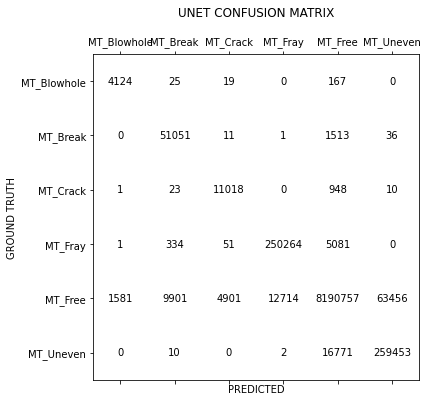

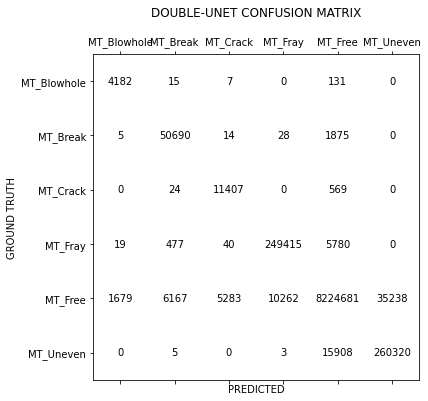

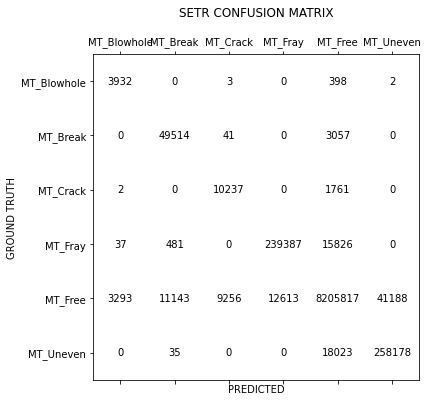

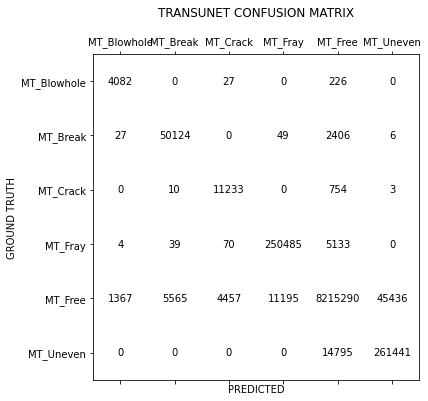

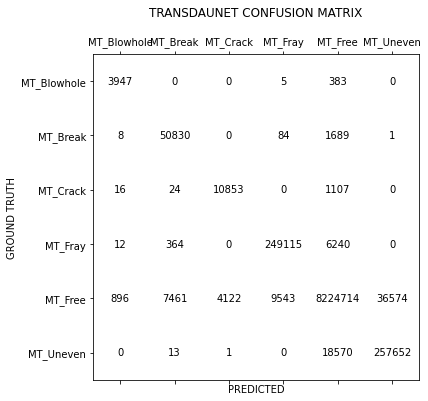

In [ ]:
# CM
# plot_confusion_matrix(FCN_test_cm, title='FCN CONFUSION MATRIX\n')
# plot_confusion_matrix(DNET_test_cm, title='DILATEDNET CONFUSION MATRIX\n')
plot_confusion_matrix(UNET_test_cm, title='UNET CONFUSION MATRIX\n')
# plot_confusion_matrix(DDUNET_test_cm, title='DOUBLE-UNET CONFUSION MATRIX\n')
plot_confusion_matrix(MDDUNET_test_cm, title='DOUBLE-UNET CONFUSION MATRIX\n')
plot_confusion_matrix(SETR_test_cm, title='SETR CONFUSION MATRIX\n')
plot_confusion_matrix(TRANSUNET_test_cm, title='TRANSUNET CONFUSION MATRIX\n')
plot_confusion_matrix(TRANSDAUNET_test_cm, title='TRANSDAUNET CONFUSION MATRIX\n')

In [ ]:
# PA_IOU
# TP_TN_FP_FN_PA_IOU_DICE([FCN_test_cm, DNET_test_cm, UNET_test_cm, MDDUNET_test_cm, SETR_test_cm, TRANSUNET_test_cm, TRANSDAUNET_test_cm], ["FCN", "UNET", "DNET", "DDUNET", "SETR", "TRANSUNET", "TRANSDAUNET"])
TP_TN_FP_FN_PA_IOU_DICE([UNET_test_cm, MDDUNET_test_cm, SETR_test_cm, TRANSUNET_test_cm, TRANSDAUNET_test_cm], ["DNET", "DDUNET", "SETR", "TRANSUNET", "TRANSDAUNET"])

                         | DNET			| DDUNET		| SETR			| TRANSUNET		| TRANSDAUNET
*************************|**********************|***********************|***********************|***********************|***********************
True Positive 		 | 4124.00 		| 4182.00 		| 3932.00 		| 4082.00 		| 3947.00
True Negative 		 | 8878306.00 		| 8878186.00 		| 8876557.00 		| 8878491.00 		| 8878957.00
False Positive 		 | 1583.00 		| 1703.00 		| 3332.00 		| 1398.00 		| 932.00
False Negative 		 | 211.00 		| 153.00 		| 403.00 		| 253.00 		| 388.00
Precision Rate 		 | 72.26 		| 71.06 		| 54.13 		| 74.49 		| 80.90
Recall Rate 		 | 95.13 		| 96.47 		| 90.70 		| 94.16 		| 91.05
Pixel Accuracy 		 | 99.98 		| 99.98 		| 99.96 		| 99.98 		| 99.99
Intersection Over Union  | 69.69 		| 69.26 		| 51.28 		| 71.20 		| 74.94
Dice Score 		 | 82.14 		| 81.84 		| 67.80 		| 83.18 		| 85.67
--------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# IoU_score_test_FCN, dice_score_test_FCN = DICE_IOU(y_true_test, y_pred_test_FCN_mask)
# IoU_score_test_UNET, dice_score_test_UNET = DICE_IOU(y_true_test, y_pred_test_UNET_mask)
# IoU_score_test_DNET, dice_score_test_DNET = DICE_IOU(y_true_test, y_pred_test_DNET_mask)
# IoU_score_test_DDNET, dice_score_test_DDNET = DICE_IOU(y_true_test, y_pred_test_DDUNET_mask)
# mean_IoU_score_test_FCN = mean_IOU(y_true_test_flatten, y_pred_test_FCN_flatten)
# mean_IoU_score_test_DNET = mean_IOU(y_true_test_flatten, y_pred_test_DNET_flatten)
mean_IoU_score_test_UNET = mean_IOU(y_true_test_flatten, y_pred_test_UNET_flatten)
# mean_IoU_score_test_DDUNET = mean_IOU(y_true_test_flatten, y_pred_test_DDUNET_flatten)
mean_IoU_score_test_MDDUNET = mean_IOU(y_true_test_flatten, y_pred_test_MDDUNET_flatten)
mean_IoU_score_test_SETR = mean_IOU(y_true_test_flatten, y_pred_test_SETR_flatten)
mean_IoU_score_test_TRANSUNET = mean_IOU(y_true_test_flatten, y_pred_test_TRANSUNET_flatten)
mean_IoU_score_test_TRANSDAUNET = mean_IOU(y_true_test_flatten, y_pred_test_TRANSDAUNET_flatten)

print('                         | ' + "UNET" + '\t\t | ' + "DOUBLEUNET" + '\t | ' + "SETR" + '\t\t | ' + "TRANSUNET" + '\t | ' + "TRANSDAUNET")
print("*************************|" + '***************|***************|***************|***************|***************')
print("Intersection over Union :| " + 
    #  "{:.2f}".format(mean_IoU_score_test_FCN*100) + "\t | " + 
    #  "{:.2f}".format(mean_IoU_score_test_DNET*100) + "\t | " +
     "{:.2f}".format(mean_IoU_score_test_UNET*100) + "\t | " +
    #  "{:.2f}".format(mean_IoU_score_test_DDUNET*100) + "\t | " +
     "{:.2f}".format(mean_IoU_score_test_MDDUNET*100) + "\t | " +
     "{:.2f}".format(mean_IoU_score_test_SETR*100) + "\t | " +
     "{:.2f}".format(mean_IoU_score_test_TRANSUNET*100) + "\t | " +
     "{:.2f}".format(mean_IoU_score_test_TRANSDAUNET*100))
# print("Dice Score \t\t:| " + 
#      "{:.8f}".format(dice_score_test_FCN) + "\t\t| " + 
#      "{:.8f}".format(dice_score_test_UNET) + "\t\t| " +
#      "{:.8f}".format(dice_score_test_DNET) + "\t\t| " +
#      "{:.8f}".format(dice_score_test_DDUNET))
print("*************************|" + '***************|***************|***************|***************|***************')

                         | UNET		 | DOUBLEUNET	 | SETR		 | TRANSUNET	 | TRANSDAUNET
*************************|***************|***************|***************|***************|***************
Intersection over Union :| 80.65	 | 82.81	 | 74.25	 | 83.19	 | 83.58
*************************|***************|***************|***************|***************|***************


In [ ]:
# from sklearn.preprocessing import label_binarize
# y_true_test = label_binarize(y_true_test_flatten, classes=[*range(len(lb.classes_))])
# y_pred_test_FCN = label_binarize(y_pred_test_FCN_flatten, classes=[*range(len(lb.classes_))])
# y_pred_test_UNET = label_binarize(y_pred_test_UNET_flatten, classes=[*range(len(lb.classes_))])
# y_pred_test_DNET = label_binarize(y_pred_test_DNET_flatten, classes=[*range(len(lb.classes_))])

# plot_PR_curve(y_true_test, [y_pred_test_FCN, y_pred_test_UNET, y_pred_test_DNET], ["FCN", "UNET", "DNET"])

In [ ]:
# plot_roc_curve(y_true_test, [y_pred_test_FCN, y_pred_test_UNET, y_pred_test_DNET], ["FCN", "UNET", "DNET"])

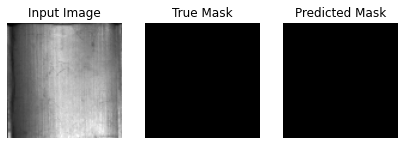

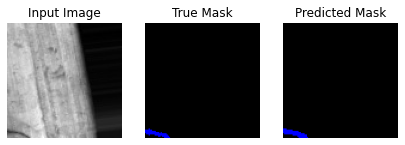

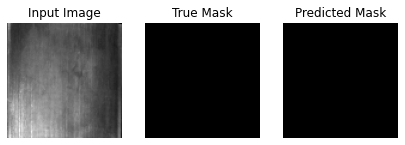

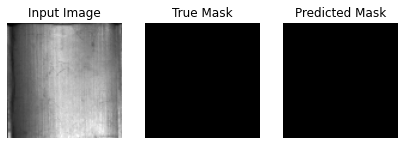

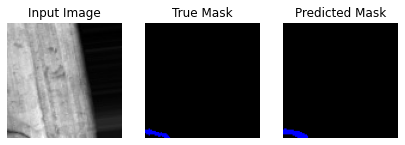

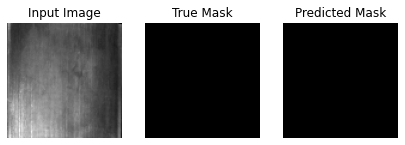

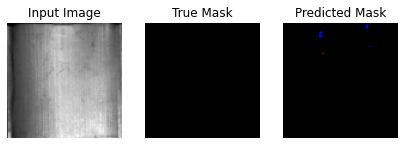

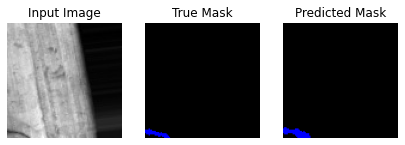

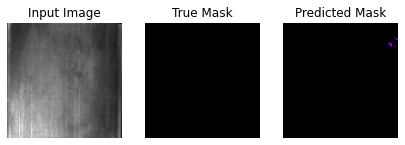

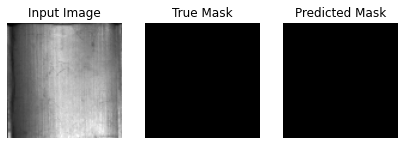

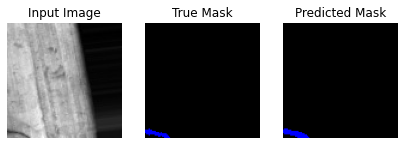

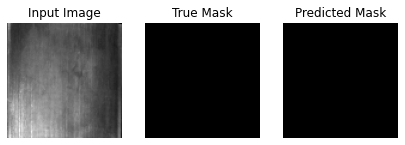

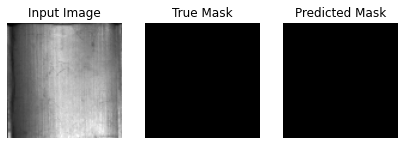

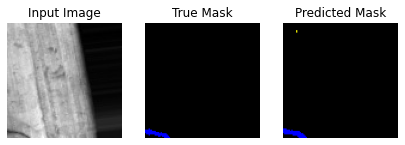

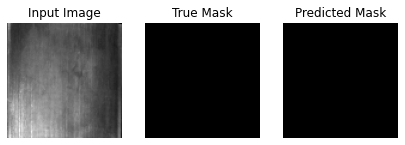

In [ ]:
# Display some predictions
import random
random.seed(1)
l = 3
r = random.sample(range(0, 1000), l)
# show_prediction_sample(test_images[r], test_labels_iou[r], y_pred_test_FCN_mask[r], l)
# show_prediction_sample(test_images[r], test_labels_iou[r], y_pred_test_DNET_mask[r], l)
show_prediction_sample(test_images[r], test_labels_iou[r], y_pred_test_UNET_mask[r], l)
# show_prediction_sample(test_images[r], test_labels_iou[r], y_pred_test_DDUNET_mask[r], l)
show_prediction_sample(test_images[r], test_labels_iou[r], y_pred_test_MDDUNET_mask[r], l)
show_prediction_sample(test_images[r], test_labels_iou[r], y_pred_test_SETR_mask[r], l)
show_prediction_sample(test_images[r], test_labels_iou[r], y_pred_test_TRANSUNET_mask[r], l)
show_prediction_sample(test_images[r], test_labels_iou[r], y_pred_test_TRANSDAUNET_mask[r], l)

## EXTRA: DEMO

Sample images: 
0.   **Blowhole** - exp1_num_3667
1.   **Break** - exp1_num_26106
2.   **Crack** - exp1_num_3191
3.   **Fray** - exp1_num_20362
4.   **Free** - exp1_num_10181
5.   **Uneven** - exp1_num_124236

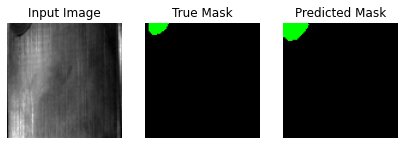

Inference time: 0.1467773809999926 s


In [ ]:
# FCN
start = time.perf_counter()

image = cv2.imread("/content/Magnetic_Tile/MT_Break/Imgs/exp1_num_26106.jpg")
image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = cv2.imread("/content/Magnetic_Tile/MT_Break/Imgs/exp1_num_26106.png")
mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = (mask > 0).astype(bool)
mask_iou = np.zeros(mask.shape)
for i in range(mask.shape[0]):
    mask_iou[i] = np.where(mask[i] == True, 1, 4)
image = image[np.newaxis, ...]
mask_iou = mask_iou[np.newaxis, ...]

datagen = ImageDataGenerator()
datagen.fit(image, augment=False)
generator = datagen.flow(x=image, y=mask_iou, batch_size=1)

show_prediction_sample(image, mask_iou, np.argmax(FCN.predict(image), axis=3).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1), 1)

end = time.perf_counter()
print("Inference time:", end - start, "s")

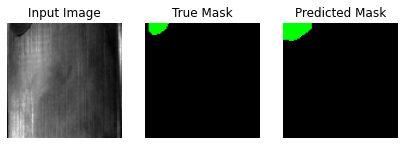

Inference time: 0.9642600999999331 s


In [ ]:
# DNET
start = time.perf_counter()

image = cv2.imread("/content/Magnetic_Tile/MT_Break/Imgs/exp1_num_26106.jpg")
image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = cv2.imread("/content/Magnetic_Tile/MT_Break/Imgs/exp1_num_26106.png")
mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = (mask > 0).astype(bool)
mask_iou = np.zeros(mask.shape)
for i in range(mask.shape[0]):
    mask_iou[i] = np.where(mask[i] == True, 1, 4)
image = image[np.newaxis, ...]
mask_iou = mask_iou[np.newaxis, ...]

datagen = ImageDataGenerator()
datagen.fit(image, augment=False)
generator = datagen.flow(x=image, y=mask_iou, batch_size=1)

show_prediction_sample(image, mask_iou, np.argmax(DNET.predict(image), axis=3).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1), 1)

end = time.perf_counter()
print("Inference time:", end - start, "s")

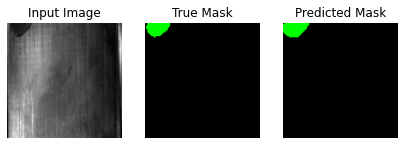

Inference time: 0.4012058949997481 s


In [ ]:
# UNET
start = time.perf_counter()

image = cv2.imread("/content/Magnetic_Tile/MT_Break/Imgs/exp1_num_26106.jpg")
image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = cv2.imread("/content/Magnetic_Tile/MT_Break/Imgs/exp1_num_26106.png")
mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = (mask > 0).astype(bool)
mask_iou = np.zeros(mask.shape)
for i in range(mask.shape[0]):
    mask_iou[i] = np.where(mask[i] == True, 1, 4)
image = image[np.newaxis, ...]
mask_iou = mask_iou[np.newaxis, ...]

datagen = ImageDataGenerator()
datagen.fit(image, augment=False)
generator = datagen.flow(x=image, y=mask_iou, batch_size=1)

show_prediction_sample(image, mask_iou, np.argmax(UNET.predict(image), axis=3).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1), 1)

end = time.perf_counter()
print("Inference time:", end - start, "s")

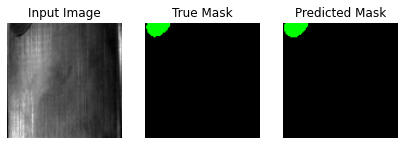

Inference time: 0.4122258980000879 s


In [ ]:
# DOUBLE U-NET
start = time.perf_counter()

image = cv2.imread("/content/Magnetic_Tile/MT_Break/Imgs/exp1_num_26106.jpg")
image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = cv2.imread("/content/Magnetic_Tile/MT_Break/Imgs/exp1_num_26106.png")
mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = (mask > 0).astype(bool)
mask_iou = np.zeros(mask.shape)
for i in range(mask.shape[0]):
    mask_iou[i] = np.where(mask[i] == True, 1, 4)
image = image[np.newaxis, ...]
mask_iou = mask_iou[np.newaxis, ...]

datagen = ImageDataGenerator()
datagen.fit(image, augment=False)
generator = datagen.flow(x=image, y=mask_iou, batch_size=1)

show_prediction_sample(image, mask_iou, np.argmax(MDDUNET.predict(image), axis=3).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1), 1)

end = time.perf_counter()
print("Inference time:", end - start, "s")

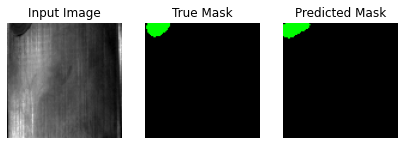

Inference time: 0.47796469099967 s


In [ ]:
# SETR
start = time.perf_counter()

image = cv2.imread("/content/Magnetic_Tile/MT_Break/Imgs/exp1_num_26106.jpg")
image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = cv2.imread("/content/Magnetic_Tile/MT_Break/Imgs/exp1_num_26106.png")
mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = (mask > 0).astype(bool)
mask_iou = np.zeros(mask.shape)
for i in range(mask.shape[0]):
    mask_iou[i] = np.where(mask[i] == True, 1, 4)
image = image[np.newaxis, ...]
mask_iou = mask_iou[np.newaxis, ...]

datagen = ImageDataGenerator()
datagen.fit(image, augment=False)
generator = datagen.flow(x=image, y=mask_iou, batch_size=1)

show_prediction_sample(image, mask_iou, np.argmax(SETR.predict(image), axis=3).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1), 1)

end = time.perf_counter()
print("Inference time:", end - start, "s")

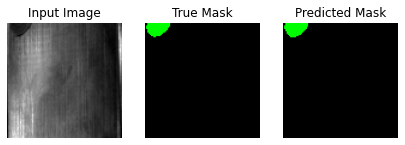

Inference time: 0.4114499870001964 s


In [ ]:
# TRANSU-NET
start = time.perf_counter()

image = cv2.imread("/content/Magnetic_Tile/MT_Break/Imgs/exp1_num_26106.jpg")
image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = cv2.imread("/content/Magnetic_Tile/MT_Break/Imgs/exp1_num_26106.png")
mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = (mask > 0).astype(bool)
mask_iou = np.zeros(mask.shape)
for i in range(mask.shape[0]):
    mask_iou[i] = np.where(mask[i] == True, 1, 4)
image = image[np.newaxis, ...]
mask_iou = mask_iou[np.newaxis, ...]

datagen = ImageDataGenerator()
datagen.fit(image, augment=False)
generator = datagen.flow(x=image, y=mask_iou, batch_size=1)

show_prediction_sample(image, mask_iou, np.argmax(TRANSUNET.predict(image), axis=3).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1), 1)

end = time.perf_counter()
print("Inference time:", end - start, "s")

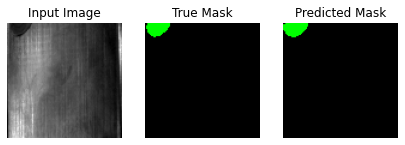

Inference time: 0.562442123999972 s


In [ ]:
# TRANSDAU-NET
start = time.perf_counter()

image = cv2.imread("/content/Magnetic_Tile/MT_Break/Imgs/exp1_num_26106.jpg")
image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = cv2.imread("/content/Magnetic_Tile/MT_Break/Imgs/exp1_num_26106.png")
mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = (mask > 0).astype(bool)
mask_iou = np.zeros(mask.shape)
for i in range(mask.shape[0]):
    mask_iou[i] = np.where(mask[i] == True, 1, 4)
image = image[np.newaxis, ...]
mask_iou = mask_iou[np.newaxis, ...]

datagen = ImageDataGenerator()
datagen.fit(image, augment=False)
generator = datagen.flow(x=image, y=mask_iou, batch_size=1)

show_prediction_sample(image, mask_iou, np.argmax(TRANSDAUNET.predict(image), axis=3).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1), 1)

end = time.perf_counter()
print("Inference time:", end - start, "s")